## Setup and imports

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import itertools
import numpy as np
import pandas as pd
from scipy import stats

sns.set_style('whitegrid')
sns.set_palette('colorblind')
 
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

MARKERS = 'o v ^ < > s p P * x X D d'.split()

In [3]:
OUTDIR = '/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/Final_figures/Github'
if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)
    
WORKDIR = '/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/'
os.chdir(WORKDIR)

In [4]:
import yaml
config = yaml.load(open('/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/snakefiles/04_evaluation/fscore.yaml'),
                   Loader=yaml.FullLoader)

#ALGORITHMS = config['algorithms']
#DATASETS = config['dataset_order']
#ALG_FIX = config['algorithm_namefix']
ALGORITHMS = sorted(config['algorithms'], key=lambda s: s.lower())
ALGORITHMS = [a for a in ALGORITHMS if a not in ['pearson', 'random']] + ['pearson']


DATASETS = [
    'gasch_GSE102475',
    'jackson_GSE125162',
    'sridharan_A2S',
    'sridharan_FBS',
    'zhao_GSE114952',
    'shalek_GSE48968',
    'han_GSE107552'
]

ALG_FIX = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}
#METRICS = config['metrics']

METRICS = [
    'fscore',
    'AUPR',
    'n_TFs',
    'precision'
]
PRIMARY_GS = ['Perturb', 'ChIP', 'Both']

# Our 10 included algorithms get the seaborn colorblind palette
# and random gets dark grey
ALG_PALETTE = sns.color_palette('colorblind') + [sns.xkcd_rgb['dark grey']]
PALETTE_MAP = {a: c for a, c in zip(ALGORITHMS, ALG_PALETTE)}

In [5]:
ALGORITHMS = ['Pearson', 'SCENIC', 'MERLIN','PIDC', 'LEAP', 'SCODE','Scribe', 'SILGGM', 'Inferelator', 'kNN-DREMI']


In [6]:
# Grouped by species
DATASETS = [
    'gasch_GSE102475',
    'jackson_GSE125162',
    'sridharan_A2S',
    'sridharan_FBS',
    'zhao_GSE114952',
    'shalek_GSE48968',
    'han_GSE107552'
]
alg_fix = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}

ALGORITHMS = [alg_fix.get(a, a) for a in ALGORITHMS]


In [7]:
ALG_FIX = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}

In [8]:
METRICS = [
    'fscore',
    'AUPR',
    'n_TFs',
    'precision'
]
PRIMARY_GS = ['Perturb', 'ChIP', 'Both']
ALG_PALETTE = sns.color_palette('colorblind') + [sns.xkcd_rgb['dark grey']]
PALETTE_MAP = {a: c for a, c in zip(ALGORITHMS, ALG_PALETTE)}

## Load network accuracy metrics

In [9]:
TOP_N = 5000

idx_cols = 'dataset algorithm proc GS_src'.split()

# Load metrics
fscores = pd.read_table('/mnt/dv/wid/projects5/Roy-singlecell/netinf_algo_comparison/results/fscores/agg_fscores.normalized.txt').set_index(idx_cols)
aupr = pd.read_table('/mnt/dv/wid/projects5/Roy-singlecell/netinf_algo_comparison/results/AUPR/agg_AUPR.normalized.txt').set_index(idx_cols)
predTFs = pd.read_table('/mnt/dv/wid/projects5/Roy-singlecell/netinf_algo_comparison/results/predictable_TFs/agg_predictable_TFs.normalized.txt').set_index(idx_cols)

# Choose top N edges (except AUPR, which is based on all edges)
fscores = fscores.loc[fscores.n_edges == TOP_N].drop('n_edges', axis=1)
predTFs = predTFs.loc[predTFs.n_edges == TOP_N].drop('n_edges', axis=1)
aupr = aupr.loc[aupr.n_edges == 'all_edges'].drop('n_edges', axis=1)

# Concatenate metrics and toss what we don't care about
scores = pd.concat([fscores, aupr, predTFs], axis=1).reset_index()
scores = scores.loc[~scores.GS_src.str.endswith('KDUnion_c2')].copy()

scores.algorithm = scores.algorithm.replace(ALG_FIX)
scores = scores.loc[scores.algorithm.isin(ALGORITHMS)]
scores = scores.drop(['proc', 'pred_TFs'], axis=1)

Clean up gold standard names

In [10]:
cell_types = 'yeast mESC mDC hESC'.split()
def clean_GS_src(GS_src):
    data = GS_src.split("_")
    if data[0] in cell_types:
        return '_'.join(data[1:])
    else:
        return '_'.join(data)
    
# Strip cell type labels from gold standard names
scores.GS_src = scores.GS_src.apply(clean_GS_src)

# and renanme the three primary gold standards
scores.GS_src = scores.GS_src.replace({'KDUnion': 'Perturb', 
                                       'chipunion': 'ChIP',
                                       'chipunion_KDUnion_intersect': 'Perturb+ChIP'})

Tidy scores

In [11]:
scores = pd.melt(scores, 
                 id_vars=['dataset', 'algorithm', 'GS_src'],
                 value_vars=METRICS,
                 var_name='metric',
                 value_name='score')

In [12]:
scores

dataset algorithm        GS_src     metric   score
0     gasch_GSE102475      LEAP            hu     fscore  0.0109
1     gasch_GSE102475      LEAP          mac2     fscore  0.0331
2     gasch_GSE102475      LEAP       Perturb     fscore  0.0293
3     gasch_GSE102475      LEAP          ChIP     fscore  0.0338
4     gasch_GSE102475      LEAP  Perturb+ChIP     fscore  0.0624
...               ...       ...           ...        ...     ...
2047   zhao_GSE114952   Pearson    escapechip  precision  0.2834
2048   zhao_GSE114952   Pearson           lit  precision  0.0996
2049   zhao_GSE114952   Pearson         logof  precision  0.1576
2050   zhao_GSE114952   Pearson     nishiyama  precision  0.1070
2051   zhao_GSE114952   Pearson    scATAC_q10  precision  0.1538

[2052 rows x 5 columns]

## Load benchmarking data

In [13]:
# ALGORITHMS = 'inferelator kNN-DREMI LEAP PIDC Scribe SILGGM MERLIN SCENIC SCODE'.split()
# # ALGORITHMS = 'HurdleNormal inferelator kNN-DREMI LEAP PIDC Scribe SCHiRM SILGGM MERLIN SCENIC SCODE'.split()
# ALGORITHMS = sorted(ALGORITHMS, key=lambda s: s.lower())

# ALGORITHMS = ALGORITHMS + 'pearson BTR HurdleNormal SCHiRM'.split()

# alg_fix = {
#     'inferelator': 'Inferelator',
#     'knnDREMI': 'kNN-DREMI',
#     'pearson': 'Pearson',
#     'random': 'Random'
# }

# ALGORITHMS = [alg_fix.get(a, a) for a in ALGORITHMS]

In [14]:
dfs = []    
for alg in ALGORITHMS:
    if alg == 'Random':
        continue

    df = pd.read_table('/mnt/dv/wid/projects5/Roy-singlecell/netinf_algo_comparison/results/benchmark/{alg}/resource_usage.txt'.format(alg=alg))
    dfs.append(df)
    
resources = pd.concat(dfs).reset_index(drop=True)
resources = resources.loc[resources.n_genes > 0]
resources.algorithm = resources.algorithm.replace(ALG_FIX)

## Compute aggregate ranks

Runtime and memory ranks

In [15]:
resources

algorithm  n_genes       time      mem
0     Pearson       10       1.29    77992
1     Pearson       25       0.80    82252
2     Pearson       50       0.84    83376
3     Pearson      100       1.18    95648
4     Pearson      250       4.39   102352
..        ...      ...        ...      ...
93  kNN-DREMI      500    3650.45   143496
94  kNN-DREMI     1000   13523.51   199460
95  kNN-DREMI     2000   43571.48   354788
96  kNN-DREMI     5000  256014.24  1029180
97  kNN-DREMI     8000  646007.07  1938204

[96 rows x 4 columns]

In [16]:
# Compute ranks wrt largest benchmark set (8k genes)
benchmark_ranks = pd.melt(resources.loc[(resources.n_genes == 8000) |
                                        ((resources.algorithm == 'Scribe') & (resources.n_genes == 2000))],
                          id_vars=['algorithm'],
                          value_vars=['time', 'mem'],
                          var_name='metric',
                          value_name='score')

# Scribe didn't complete on full gene benchmark
benchmark_ranks.loc[(benchmark_ranks.algorithm == 'Scribe') & (benchmark_ranks.metric == 'mem'), 'score'] = np.nan

# Rank algorithm performance wrt runtime and memory
benchmark_ranks['rank'] = benchmark_ranks.groupby(['metric'])['score']\
                                         .rank(ascending=True, method='average')

# Re-organize for heatmap
benchmark_ranks = benchmark_ranks.pivot_table(columns='algorithm', index='metric', values='rank')
benchmark_ranks = benchmark_ranks.loc[['time', 'mem'], ALGORITHMS]

Network accuracy ranks

In [17]:
scores['rank'] = scores.groupby(['dataset', 'GS_src', 'metric'])['score']\
                       .rank(ascending=False, method='average')

# Take median over our primary 21 comparisons, and exclude random
summary = scores.loc[scores.GS_src.isin(PRIMARY_GS) &
                     (scores.algorithm != 'Random')]\
                .groupby(['algorithm', 'metric'])['rank'].median().reset_index()

# Re-organize for heatmap
summary = summary.pivot_table(columns='algorithm', index='metric', values='rank')
summary = summary.loc[METRICS, ALGORITHMS]

In [18]:
summary

algorithm  Pearson  SCENIC  MERLIN  PIDC  LEAP  SCODE  Scribe  SILGGM  \
metric                                                                  
fscore         3.5     3.5     2.5   3.5   6.0   5.25     5.5     8.0   
AUPR           3.0     3.0     4.5   5.5   6.0   4.00     5.0     8.5   
n_TFs          2.5     3.5     3.0   3.0   5.0   6.25     8.0     8.5   
precision      3.0     4.0     5.5   3.0   6.0   5.00     5.5     8.0   

algorithm  Inferelator  kNN-DREMI  
metric                             
fscore            7.00        9.0  
AUPR              7.00        7.5  
n_TFs             6.00        8.5  
precision         6.75        9.0

In [19]:
benchmark_ranks

algorithm  Pearson  SCENIC  MERLIN  PIDC  LEAP  SCODE  Scribe  SILGGM  \
metric                                                                  
time           4.0     1.0     7.0   9.0   6.0    2.0    10.0     3.0   
mem            4.0     3.0     6.0   8.0   5.0    1.0     NaN     7.0   

algorithm  Inferelator  kNN-DREMI  
metric                             
time               5.0        8.0  
mem                9.0        2.0

Order algorithms based on median rank across 5 columns (runtime, memory, median F-score/AUPR/predTFs)

In [20]:
order = pd.concat([benchmark_ranks]).T.median(axis=1).sort_values(ascending=True).index
benchmark_ranks = benchmark_ranks.loc[:, order]
summary = summary.loc[:, order]

In [21]:
order

Index(['SCODE', 'SCENIC', 'Pearson', 'SILGGM', 'kNN-DREMI', 'LEAP', 'MERLIN',
       'Inferelator', 'PIDC', 'Scribe'],
      dtype='object', name='algorithm')

## Panel (a) - Overall rankings

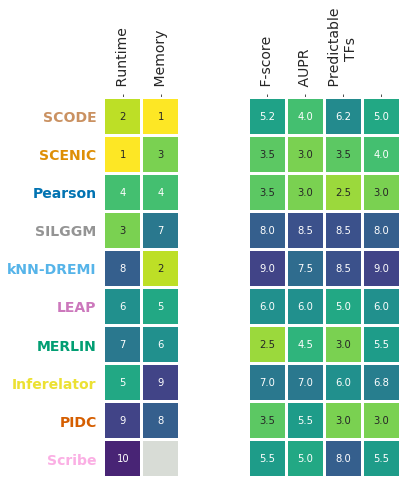

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(6, 7))

ax = axes[0]
ax = sns.heatmap(benchmark_ranks.T, ax=ax,
                 annot=True, fmt='.0f',
                 vmin=1, vmax=11,
                 cbar=False, mask=benchmark_ranks.T.isnull(),
                 cmap='viridis_r', square=True,
                 linewidths=2)

    
# Set algorithm labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
[t.set_color(PALETTE_MAP[alg]) for alg, t in zip(order, ax.yaxis.get_ticklabels())]
[t.set_fontweight('bold') for t in ax.yaxis.get_ticklabels()]

# ax.set_xticklabels([])
ax.xaxis.tick_top()
ax.set_xticklabels([' Runtime', ' Memory'], rotation=90, ha='center', va='bottom')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_facecolor(sns.xkcd_rgb['light grey'])

ax = axes[1]
ax = sns.heatmap(summary.T, ax=ax,
                 annot=True, fmt='.1f', 
                 vmin=1, vmax=11,
                 cbar=False, mask=summary.T.isnull(),
                 cmap='viridis_r', square=True,
                 linewidths=2)
        
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_yticklabels([])
ax.xaxis.tick_top()
ax.set_xticklabels([' F-score', ' AUPR', ' Predictable\nTFs'], rotation=90, ha='center', va='bottom')

# fig.suptitle('Median rank across datasets')

#plt.subplots_adjust(wspace=-0.5)

plt.savefig(os.path.join(OUTDIR, 'fig2a_overall_ranks.pdf'), bbox_inches='tight')

In [22]:
OUTDIR

'/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/Final_figures/figure_panels_Jan11'

## Panel (b) - Runtime and memory requirements

In [23]:
resources['time_hours'] = resources['time'] / 3600
resources['log_hours'] = np.log10(resources['time_hours'])
resources['mem_GB'] = resources['mem'] / (1024 * 1024)

In [24]:
second = 1 / 3600
minute = 1 / 60
hour = 1
day = 24
week = 24*7
month = 24*30

human_ticks = [second, minute, hour, day, week, month]

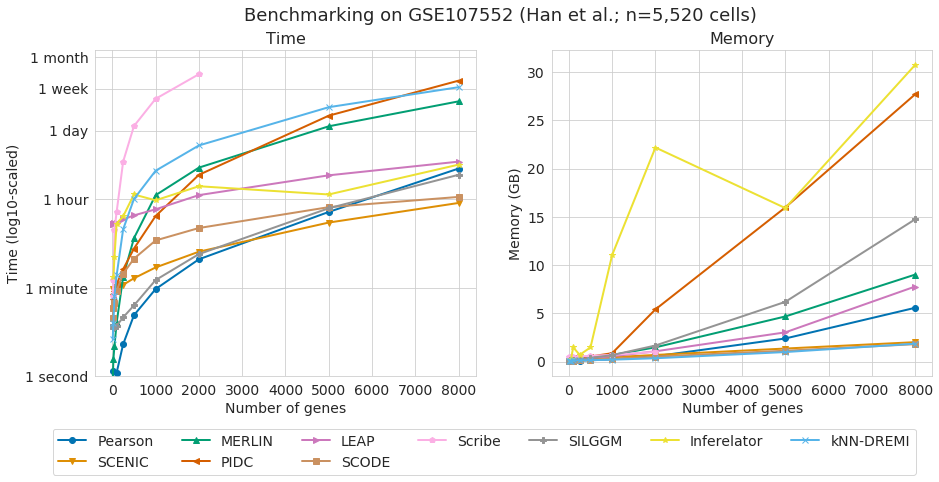

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

RESOURCES = 'log_hours mem_GB'.split()
resource_titles = {'log_hours': 'Time (log10-scaled)', 'mem_GB': 'Memory (GB)'}

for resource, ax in zip(RESOURCES, axes):
    ymax = resources[resource].max()
    
    for i, algorithm in enumerate(ALGORITHMS):
        data = resources.loc[resources.algorithm == algorithm]
        ax.plot(data.n_genes, data[resource], linewidth=2,
                marker=MARKERS[i], linestyle='-', label=algorithm)

    if resource == 'log_hours':
        ax.set_ylim(-3, 3)
        ax.set_yticks(np.log10(human_ticks))
        units = 'second minute hour day week month'.split()
        ax.set_yticklabels(['1 ' + unit for unit in units])

    ax.set_ylabel(resource_titles[resource])
    ax.set_xlabel('Number of genes')
    ax.set_title(resource_titles[resource].split()[0])
    
l = ax.legend(frameon=True, title=None, ncol=7,
              bbox_to_anchor=(0.485, 0.02), loc='upper center', 
              bbox_transform=fig.transFigure)
l.get_frame().set_linewidth(1)
l.get_title().set_fontsize(plt.rcParams['legend.fontsize'])

fig.suptitle('Benchmarking on GSE107552 (Han et al.; n=5,520 cells)')

plt.savefig(os.path.join(OUTDIR, 'fig2b_runtime_and_memory.pdf'), bbox_inches='tight')

## Dot plots

In [93]:
primary_scores = scores.loc[scores.GS_src.isin(PRIMARY_GS)].copy()

In [94]:
rand_scores = primary_scores.loc[primary_scores.algorithm == 'Random'].rename(columns={'score': 'random'})

In [101]:
primary_scores

dataset  algorithm   GS_src     metric   score  rank  random  \
0    gasch_GSE102475       LEAP  Perturb     fscore  0.0293   4.0     NaN   
1    gasch_GSE102475       LEAP     ChIP     fscore  0.0338   3.0     NaN   
2    gasch_GSE102475       LEAP     Both     fscore  0.0624   1.0     NaN   
3    gasch_GSE102475     MERLIN  Perturb     fscore  0.0212   6.0     NaN   
4    gasch_GSE102475     MERLIN     ChIP     fscore  0.0239   6.0     NaN   
..               ...        ...      ...        ...     ...   ...     ...   
787   zhao_GSE114952  kNN-DREMI     ChIP  precision  0.1430   6.0     NaN   
788   zhao_GSE114952  kNN-DREMI     Both  precision  0.0060   7.0     NaN   
789   zhao_GSE114952    Pearson  Perturb  precision  0.1336   4.0     NaN   
790   zhao_GSE114952    Pearson     ChIP  precision  0.2916   4.0     NaN   
791   zhao_GSE114952    Pearson     Both  precision  0.1830   2.0     NaN   

     rand_ratio  log_rand_ratio  
0           NaN             NaN  
1           NaN             NaN  
2           NaN             NaN  
3           NaN             NaN  
4           NaN             NaN  
..          ...             ...  
787         NaN             NaN  
788         NaN             NaN  
789         NaN             NaN  
790         NaN             NaN  
791         NaN             NaN  

[792 rows x 9 columns]

In [96]:
rand_scores

Empty DataFrame
Columns: [dataset, algorithm, GS_src, metric, random, rank]
Index: []

In [97]:
primary_scores = pd.merge(primary_scores, rand_scores.drop(['rank', 'algorithm'], axis=1),
                  on=['dataset', 'GS_src', 'metric'],
                  how='left')

In [98]:
primary_scores['rand_ratio'] = primary_scores['score'] / primary_scores['random']
primary_scores['log_rand_ratio'] = np.log2(primary_scores['rand_ratio'])

In [99]:
ALG_PALETTE = sns.color_palette('colorblind') + [sns.xkcd_rgb['dark grey']]

In [61]:
'''data = primary_scores.loc[(primary_scores.algorithm != 'Random') &
                          (primary_scores.metric == 'fscore')]



idx_order = [ALGORITHMS.index(a) for a in order]
palette = [sns.color_palette('colorblind')[i] for i in idx_order]
''''''

In [70]:
METRIC_TITLES = {
    'fscore': 'F-score',
    'AUPR': 'AUPR',
    'n_TFs': 'Predictable TFs',
    'precision': 'Precision'
}

In [71]:
data

dataset algorithm   GS_src  metric   score  rank  random  \
0    gasch_GSE102475      LEAP  Perturb  fscore  0.0293   3.0     NaN   
1    gasch_GSE102475      LEAP     ChIP  fscore  0.0338   2.0     NaN   
2    gasch_GSE102475      LEAP     Both  fscore  0.0624   1.0     NaN   
3    gasch_GSE102475    MERLIN  Perturb  fscore  0.0212   5.0     NaN   
4    gasch_GSE102475    MERLIN     ChIP  fscore  0.0239   5.0     NaN   
..               ...       ...      ...     ...     ...   ...     ...   
133   zhao_GSE114952     SCODE     ChIP  fscore  0.0551   2.5     NaN   
134   zhao_GSE114952     SCODE     Both  fscore  0.1331   1.0     NaN   
135   zhao_GSE114952    SILGGM  Perturb  fscore  0.0173   3.0     NaN   
136   zhao_GSE114952    SILGGM     ChIP  fscore  0.0137   5.0     NaN   
137   zhao_GSE114952    SILGGM     Both  fscore  0.0347   5.0     NaN   

     rand_ratio  log_rand_ratio  
0           NaN             NaN  
1           NaN             NaN  
2           NaN             NaN  
3           NaN             NaN  
4           NaN             NaN  
..          ...             ...  
133         NaN             NaN  
134         NaN             NaN  
135         NaN             NaN  
136         NaN             NaN  
137         NaN             NaN  

[138 rows x 9 columns]

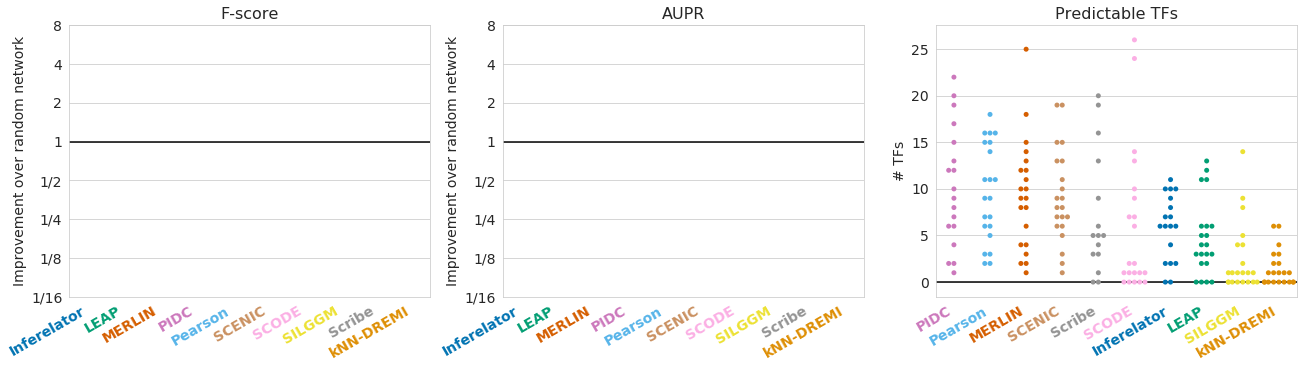

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

for metric, ax in zip(['fscore', 'AUPR', 'n_TFs'], axes):
    data = primary_scores.loc[(primary_scores.algorithm != 'Random') &
                              (primary_scores.metric == metric)]
        
    if metric == 'n_TFs':
        yval = 'score'
    else:
        yval = 'log_rand_ratio'
        
    order = data.groupby('algorithm')[yval].mean().sort_values(ascending=False).index
    idx_order = [ALGORITHMS.index(a) for a in order]
    palette = [sns.color_palette('colorblind')[i] for i in idx_order]
        
    ax = sns.swarmplot(data=data,
                       x='algorithm', order=order,
                       y=yval,
                       palette=palette,
                       ax=ax)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    [t.set_color(i) for i, t in
     zip(palette, ax.xaxis.get_ticklabels())]

    [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
#     ax.set_ylabel('Fold change\nrelative to random')
    ax.set_ylabel(None)
    ax.axhline(0, c='k')
    ax.set_xlabel(None)

    if metric != 'n_TFs':
#         ax.set_yticks([-2, -1, 0, 1])
        ax.set_yticks(np.arange(-4, 4, 1))
        ax.set_yticklabels(['1/16', '1/8', '1/4', '1/2', '1', '2', '4', '8'])
        ax.set_ylim(-4, 3)
        ax.set_ylabel('Improvement over random network')
    else:
        ax.set_ylabel('# TFs')
#     else:
#         ax.set_yticks([-1, 0, 1])
#         ax.set_yticklabels(['1/2', '1', '2'])    
    
    ax.set_title(METRIC_TITLES[metric])

    #     plt.tight_layout()
#     plt.subplots_adjust(hspace=0.45)

# plt.text(0.02, 0.5, "Fold change relative to random", 
#          fontsize=14,
#          transform=fig.transFigure,
#          rotation=90, va='center', ha='right')
# #          rotation=90, ha='center', va='bottom')
        
plt.savefig(os.path.join(OUTDIR, 'metric_performance.v2.pdf'), bbox_inches='tight')

In [50]:
data.head()

dataset algorithm   GS_src metric  score  rank  random  \
276  gasch_GSE102475      LEAP  Perturb  n_TFs    4.0   4.0     NaN   
277  gasch_GSE102475      LEAP     ChIP  n_TFs    3.0   2.0     NaN   
278  gasch_GSE102475      LEAP     Both  n_TFs    2.0   2.5     NaN   
279  gasch_GSE102475    MERLIN  Perturb  n_TFs    3.0   6.0     NaN   
280  gasch_GSE102475    MERLIN     ChIP  n_TFs    1.0   5.0     NaN   

     rand_ratio  log_rand_ratio  
276         NaN             NaN  
277         NaN             NaN  
278         NaN             NaN  
279         NaN             NaN  
280         NaN             NaN

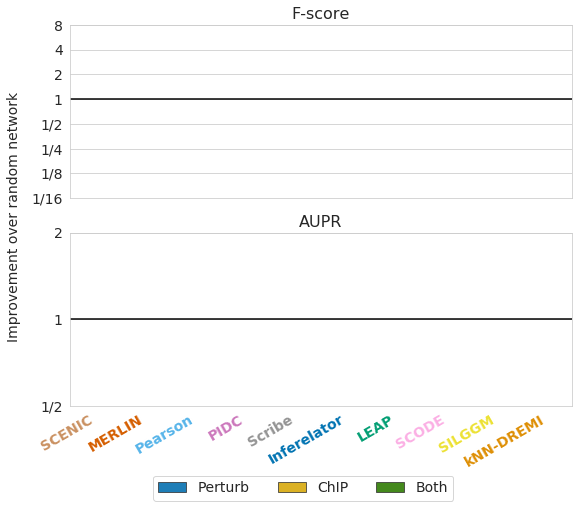

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(9, 7))

for metric, ax in zip(['fscore', 'AUPR'], axes):
    data = primary_scores.loc[(primary_scores.algorithm != 'random') &
                              (primary_scores.metric == metric)]
    
#     order = data.groupby('algorithm')[yval].mean().sort_values(ascending=False).index
    order = 'SCENIC MERLIN Pearson PIDC Scribe Inferelator LEAP SCODE SILGGM kNN-DREMI'.split()
    idx_order = [ALGORITHMS.index(a) for a in order]
    palette = [sns.color_palette('colorblind')[i] for i in idx_order]
    
    ax = sns.boxplot(data=data,
                       x='algorithm', order=order,
                       y='log_rand_ratio',
                       hue='GS_src',
                       palette=[sns.xkcd_rgb['cerulean'], sns.xkcd_rgb['goldenrod'], sns.xkcd_rgb['grass green']],
    #                    hue='GS_type', 
    #                   dodge=True, jitter=True,
                       ax=ax)
    
    if metric == 'AUPR':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
        [t.set_color(i) for i, t in zip(palette, ax.xaxis.get_ticklabels())]
        [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
        
        l = ax.legend(frameon=True, title=None, ncol=3,
              bbox_to_anchor=(0.485, 0.0), loc='upper center', 
              bbox_transform=fig.transFigure)
    else:
        ax.set_xticklabels([])
        ax.legend_ = None

    ax.set_ylabel(None)
    ax.axhline(0, c='k')
    ax.set_xlabel(None)

    if metric == 'fscore':
        ax.set_ylim(-4, 3)
        ax.set_yticks(np.arange(-4, 4, 1))
        ax.set_yticklabels(['1/16', '1/8', '1/4', '1/2', '1', '2', '4', '8'])
    else:
        ax.set_ylim(-1, 1)
        ax.set_yticks(np.arange(-1, 2, 1))
        ax.set_yticklabels(['1/2', '1', '2'])

    ax.set_ylabel(None)
    
    ax.set_title(METRIC_TITLES[metric])
    
    #     plt.tight_layout()
#     plt.subplots_adjust(hspace=0.45)

plt.text(0.05, 0.5, "Improvement over random network", 
         fontsize=14,
         transform=fig.transFigure,
         rotation=90, va='center', ha='right')
#          rotation=90, ha='center', va='bottom')
        
plt.savefig(os.path.join(OUTDIR, 'vs_random_by_GS.pdf'), bbox_inches='tight')

In [229]:
os.path.join(OUTDIR, 'vs_random_by_GS.pdf')

'/mnt/ws/home/mstone/scRNA-network-inference-comparison/notebooks/manuscript/fig2_ranking/vs_random_by_GS.pdf'

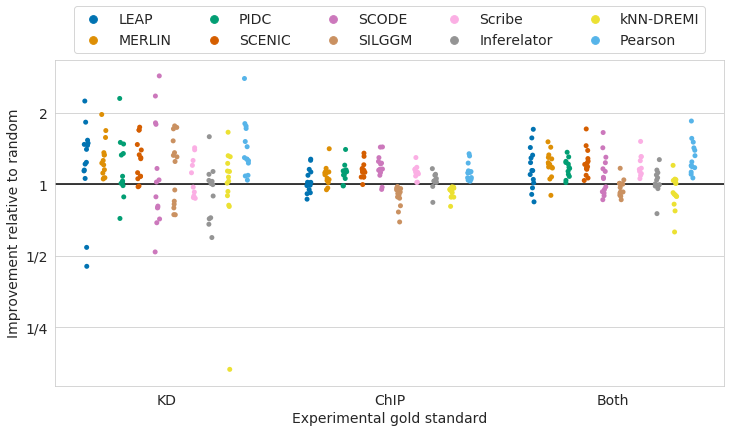

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.stripplot(data=scores.loc[scores.algorithm_x != 'random'],
                   x='GS_type',
                   y='log_rand_ratio',
                   hue='algorithm_x',
                   palette=ALG_PALETTE,
                   dodge=True, jitter=True,
                   ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
# [t.set_color(i) for i, t in
#  zip(ALG_PALETTE, ax.xaxis.get_ticklabels())]

# [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Improvement relative to random')
ax.axhline(0, c='k')
ax.set_xlabel(None)

ax.set_yticks([-2, -1, 0, 1])
ax.set_yticklabels(['1/4', '1/2', '1', '2'])

l = ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center',
              ncol=5, bbox_transform=ax.transAxes)

ax.set_xlabel('Experimental gold standard')

plt.savefig('notebooks/AUPR/figs/all_scores_stripplot.by_GS_type.pdf', bbox_inches='tight')

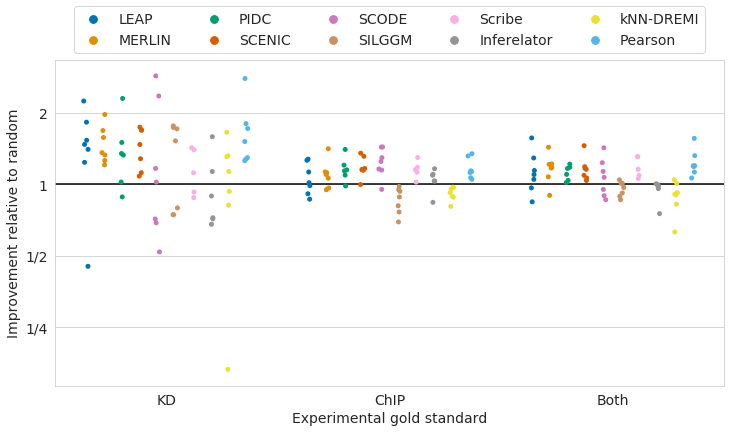

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.stripplot(data=scores.loc[(scores.algorithm_x != 'random') &
                                   (scores.metric == 'fscore')],
                   x='GS_type',
                   y='log_rand_ratio',
                   hue='algorithm_x',
                   palette=ALG_PALETTE,
                   dodge=True, jitter=True,
                   ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
# [t.set_color(i) for i, t in
#  zip(ALG_PALETTE, ax.xaxis.get_ticklabels())]

# [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Improvement relative to random')
ax.axhline(0, c='k')
ax.set_xlabel(None)

ax.set_yticks([-2, -1, 0, 1])
ax.set_yticklabels(['1/4', '1/2', '1', '2'])

l = ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center',
              ncol=5, bbox_transform=ax.transAxes)

ax.set_xlabel('Experimental gold standard')

plt.savefig('notebooks/AUPR/figs/fscore_stripplot.by_GS_type.pdf', bbox_inches='tight')

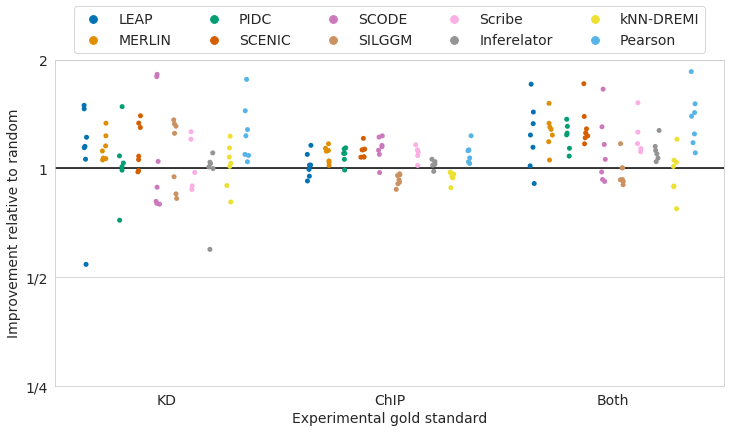

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.stripplot(data=scores.loc[(scores.algorithm_x != 'random') &
                                   (scores.metric == 'AUPR')],
                   x='GS_type',
                   y='log_rand_ratio',
                   hue='algorithm_x',
                   palette=ALG_PALETTE,
                   dodge=True, jitter=True,
                   ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
# [t.set_color(i) for i, t in
#  zip(ALG_PALETTE, ax.xaxis.get_ticklabels())]

# [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Improvement relative to random')
ax.axhline(0, c='k')
ax.set_xlabel(None)

ax.set_yticks([-2, -1, 0, 1])
ax.set_yticklabels(['1/4', '1/2', '1', '2'])

l = ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center',
              ncol=5, bbox_transform=ax.transAxes)

ax.set_xlabel('Experimental gold standard')

plt.savefig('notebooks/AUPR/figs/AUPR_stripplot.by_GS_type.pdf', bbox_inches='tight')

In [13]:
METRICS = ['fscore', 'AUPR', 'n_TFs']

In [58]:
def format_dataset(did):
    dname, geo = did.split('_')
    
    if dname == 'sridharan':
        return '{0} ({1})'.format(dname.capitalize(), geo)
    else:
        return dname.capitalize()

In [126]:
dataset = 'zhao_GSE114952'
metric = 'fscore'

df = scores.loc[(scores.dataset == dataset) &
                        (scores.metric == metric)]
        

hmap = df.pivot_table(columns='algorithm', 
                      index='GS_src', 
                      values='score')

In [19]:
METRIC_TITLES = {
    'fscore': 'F-score',
    'AUPR': 'AUPR',
    'n_TFs': 'Predictable TFs'
}

In [60]:
scores.head()

dataset algorithm   GS_src  metric   score  rank
0  gasch_GSE102475      LEAP       hu  fscore  0.0109  11.0
1  gasch_GSE102475      LEAP     mac2  fscore  0.0331   7.0
2  gasch_GSE102475      LEAP  Perturb  fscore  0.0293   4.0
3  gasch_GSE102475      LEAP     ChIP  fscore  0.0338   3.0
4  gasch_GSE102475      LEAP     Both  fscore  0.0624   1.0

In [62]:
scores.algorithm.unique()

array(['LEAP', 'MERLIN', 'PIDC', 'SCENIC', 'SCODE', 'SILGGM', 'Scribe',
       'Inferelator', 'kNN-DREMI', 'Pearson', 'Random'], dtype=object)

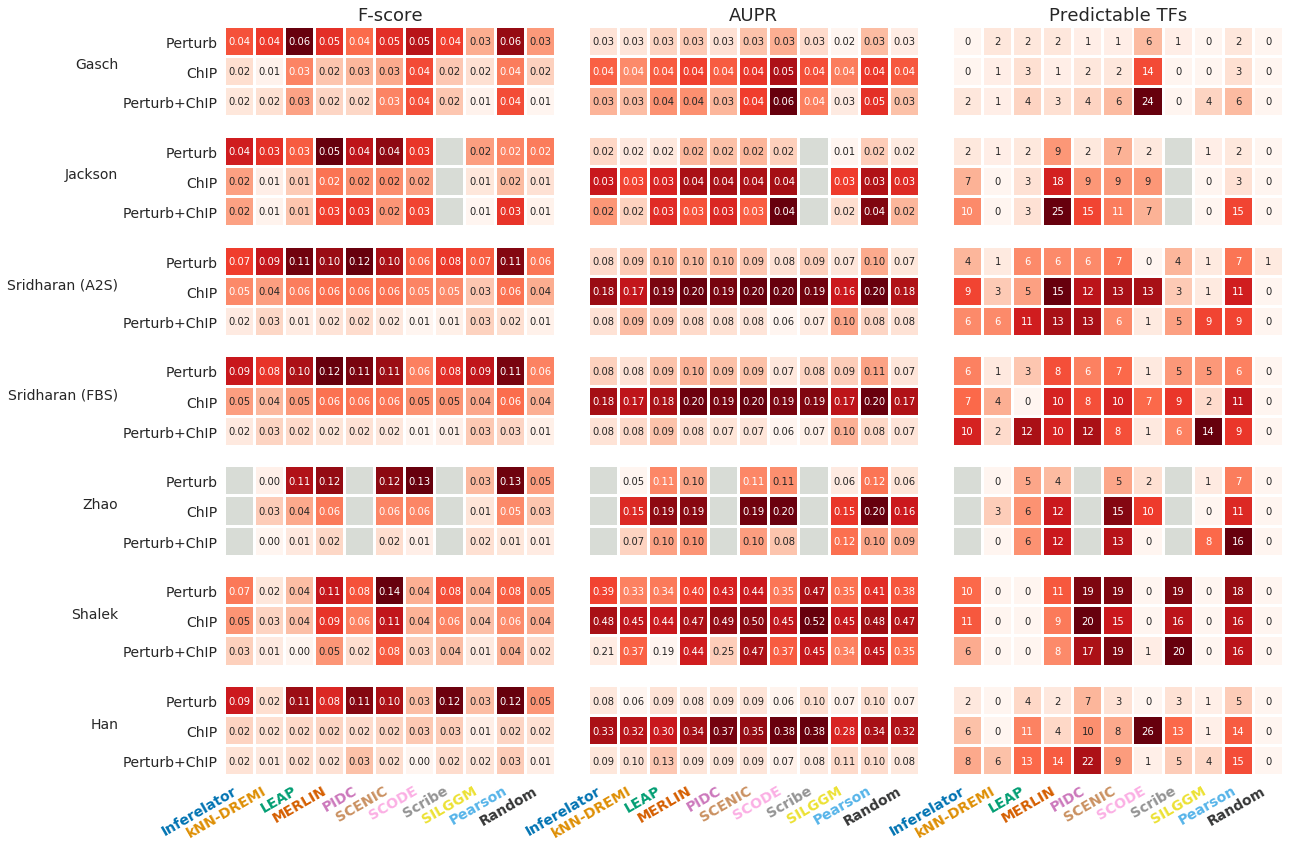

In [71]:
fig, axes = plt.subplots(7, 3, figsize=(18, 12))

for i, (dataset, axrow) in enumerate(zip(DATASETS, axes)):     
    for j, (metric, ax) in enumerate(zip(METRICS, axrow)):
        df = scores.loc[(scores.dataset == dataset) &
                        (scores.metric == metric) &
                        (scores.GS_src.isin(PRIMARY_GS))]
        
        hmap = df.pivot_table(columns='algorithm', 
                              index='GS_src', 
                              values='score')\
                 .loc[:, ALGORITHMS]
        
        fmt = '.0f' if metric == 'n_TFs' else '.02f'
        ax = sns.heatmap(hmap, ax=ax,
                         annot=True, fmt=fmt, 
                         cbar=False, mask=hmap.isnull(),
                         cmap='Reds', square=True,
                         linewidths=2)
        
        if j == 0:
            ax.set_yticklabels(['Perturb', 'ChIP', 'Perturb+ChIP'])
            ax.set_ylabel(format_dataset(dataset), rotation=0, ha='right')
        else:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
            
        if i < 6:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(ALGORITHMS, rotation=30, ha='right')
            [t.set_color(i) for i, t in
             zip(ALG_PALETTE, ax.xaxis.get_ticklabels())]

            [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
            
        if i == 0:
            ax.set_title(METRIC_TITLES[metric], fontsize=18)
            
        ax.set_xlabel(None)
        ax.set_facecolor(sns.xkcd_rgb['light grey'])
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig(os.path.join(OUTDIR, 'fig2s1_dataset_scores.pdf'), bbox_inches='tight')

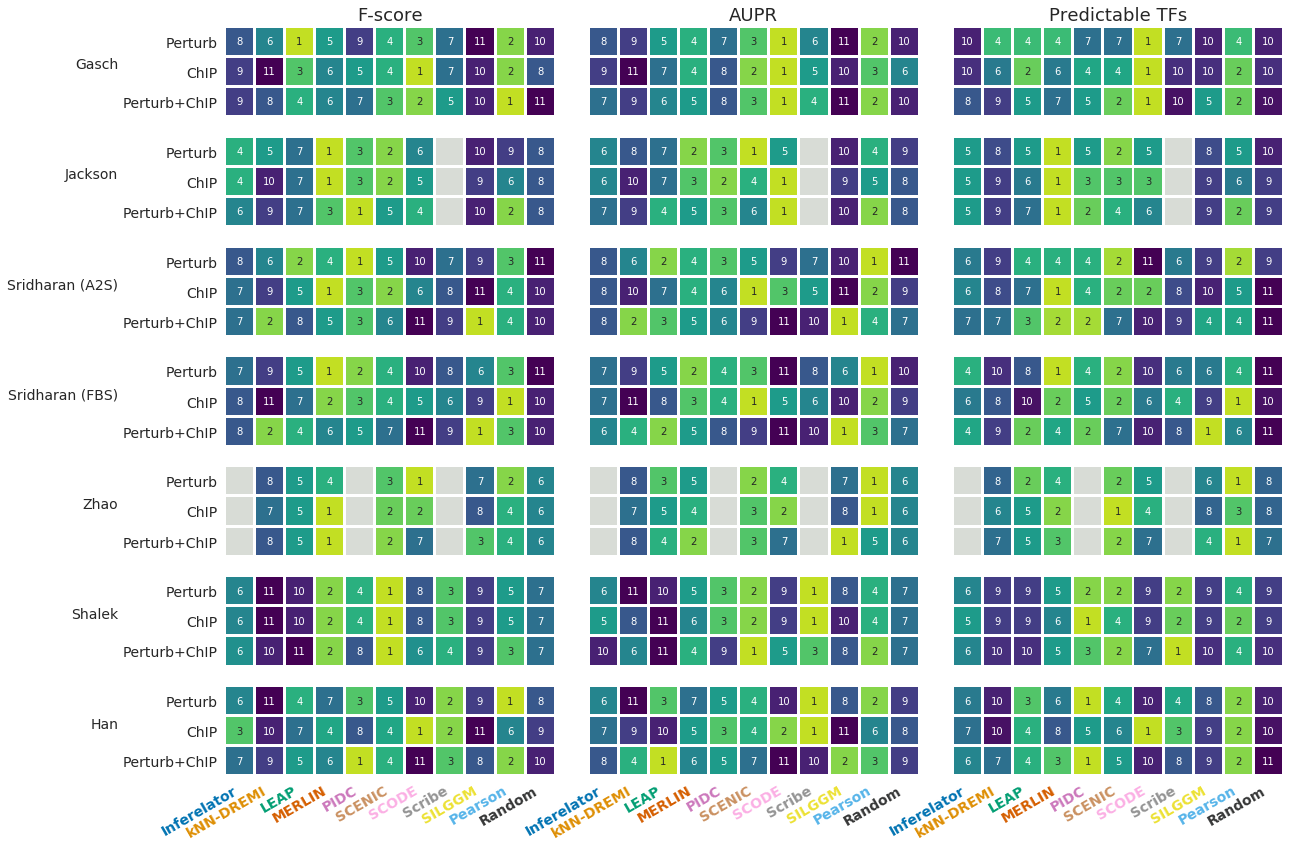

In [78]:
fig, axes = plt.subplots(7, 3, figsize=(18, 12))

for i, (dataset, axrow) in enumerate(zip(DATASETS, axes)):     
    for j, (metric, ax) in enumerate(zip(METRICS, axrow)):
        df = scores.loc[(scores.dataset == dataset) &
                        (scores.metric == metric) &
                        (scores.GS_src.isin(PRIMARY_GS))]
        
        hmap = df.pivot_table(columns='algorithm', 
                              index='GS_src', 
                              values='rank')\
                 .loc[:, ALGORITHMS]
        
        fmt = '.0f'
        ax = sns.heatmap(hmap, ax=ax,
                         annot=True, fmt=fmt, 
                         cbar=False, mask=hmap.isnull(),
                         cmap='viridis_r', square=True,
                         vmin=0, vmax=11,
                         linewidths=2)
        
        if j == 0:
            ax.set_yticklabels(['Perturb', 'ChIP', 'Perturb+ChIP'])
            ax.set_ylabel(format_dataset(dataset), rotation=0, ha='right')
        else:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
            
        if i < 6:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(ALGORITHMS, rotation=30, ha='right')
            [t.set_color(i) for i, t in
             zip(ALG_PALETTE, ax.xaxis.get_ticklabels())]

            [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
            
        if i == 0:
            ax.set_title(METRIC_TITLES[metric], fontsize=18)
            
        ax.set_xlabel(None)
        ax.set_facecolor(sns.xkcd_rgb['light grey'])
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig(os.path.join(OUTDIR, 'fig2s2_dataset_ranks.pdf'), bbox_inches='tight')

In [37]:
scores.query('metric == metric').groupby(['algorithm', 'simple_GS_src'])['rank'].median().reset_index().pivot_table(columns='algorithm', index='simple_GS_src', values='rank').loc[:, ALGORITHMS]

algorithm                    inferelator  knnDREMI  LEAP  MERLIN  PIDC  \
simple_GS_src                                                            
KDUnion                              8.0       7.0   4.0     5.0   4.5   
chipunion                            7.0       9.0   7.0     4.5   3.0   
chipunion_KDUnion_intersect          8.0       8.0   5.0     4.0   3.5   

algorithm                    SCENIC  SCODE  Scribe  SILGGM  pearson  random  
simple_GS_src                                                                
KDUnion                         5.5    7.0     9.0     3.0      3.0     8.0  
chipunion                       3.0    2.0     5.0    10.0      3.0     8.0  
chipunion_KDUnion_intersect     3.0    7.0     5.0     8.0      2.0     9.0

In [178]:
    df = scores.loc[(scores.metric == metric) &
                    (scores.GS_src.isin(primary_GS))]

In [180]:
df.groupby(['algorithm', 'GS_src'])['rank'].median()\
  .reset_index()\
  .pivot_table(columns='algorithm', index='GS_src', values='rank')\

algorithm  Inferelator  LEAP  MERLIN  PIDC  Pearson  Random  SCENIC  SCODE  \
GS_src                                                                       
Both               6.5   5.0     4.0   3.5      2.0     9.0     3.0    9.0   
ChIP               7.0   7.0     4.0   3.5      3.0     8.0     2.0    2.0   
Knockdown          7.5   4.0     5.0   7.0      3.0     7.0     6.0    7.0   

algorithm  SILGGM  Scribe  kNN-DREMI  
GS_src                                
Both          8.0     6.0        9.0  
ChIP         10.0     5.0       10.0  
Knockdown     2.0    10.0        6.0

In [51]:
hmaps = []
for metric in ['fscore', 'AUPR', 'n_TFs']:
    df = scores.loc[(scores.metric == metric) &
                    (scores.algorithm != 'Random') &
                    (scores.GS_src.isin(primary_GS))]
    hmap = df.groupby(['algorithm', 'GS_src'])['rank'].median()\
          .reset_index()\
          .pivot_table(columns='algorithm', index='GS_src', values='rank')
    
    hmaps.append(hmap)
    
hmap = pd.concat(hmaps)

In [52]:
alg_order = hmap.mean(axis=0).sort_values(ascending=True).index
idx_order = [ALGORITHMS.index(a) for a in alg_order]
color_order = [ALG_PALETTE[i] for i in idx_order]

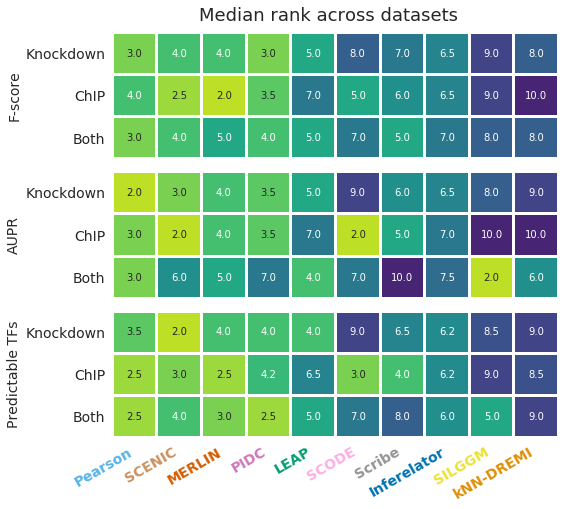

In [56]:
fig, axes = plt.subplots(3, 1, figsize=(8, 7))

for i, (metric, ax) in enumerate(zip(['fscore', 'AUPR', 'n_TFs'], axes)):
    df = scores.loc[(scores.metric == metric) &
                    (scores.algorithm != 'Random') &
                    (scores.GS_src.isin(primary_GS))]
    hmap = df.groupby(['algorithm', 'GS_src'])['rank'].median()\
          .reset_index()\
          .pivot_table(columns='algorithm', index='GS_src', values='rank')\
          .loc[:, alg_order]
    
    fmt = '.1f'
    ax = sns.heatmap(hmap, ax=ax,
                     annot=True, fmt=fmt, 
                     vmin=1, vmax=11,
                     cbar=False, mask=hmap.isnull(),
                     cmap='viridis_r', square=False,
                     linewidths=2)
    
    if i < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(alg_order, rotation=30, ha='right')
        [t.set_color(i) for i, t in zip(color_order, ax.xaxis.get_ticklabels())]
        [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]
        
    ax.set_xlabel(None)
    ax.set_ylabel(METRIC_TITLES[metric])
    ax.set_yticklabels(['Knockdown', 'ChIP', 'Both'], rotation=0, ha='right')

fig.suptitle('Median rank across datasets')

plt.subplots_adjust(hspace=0.1, top=0.93)

plt.savefig(os.path.join(OUTDIR, 'fig2e_median_rank.top_5000.pdf'), bbox_inches='tight')

[None, None, None, None, None, None, None, None, None, None, None]

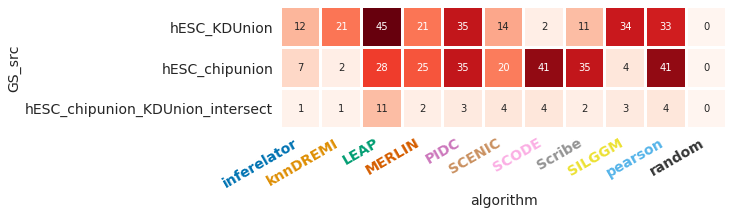

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.heatmap(hmap, ax=ax,
                 annot=True, fmt=fmt, 
                 cbar=False, mask=hmap.isnull(),
                 cmap='Reds', square=True,
                 linewidths=2)

ax.set_xticklabels(ALGORITHMS, rotation=30, ha='right')
[t.set_color(i) for i, t in
 zip(ALG_PALETTE, ax.xaxis.get_ticklabels())]
    
[t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]

In [101]:
?ax.set_xticklabels

In [103]:
sns.color_palette('colorblind') + [sns.xkcd_rgb['black']]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 '#000000']

In [152]:
scores['GS_class'] = scores.GS_src.apply(name_class)
scores['cell_type'] = scores.dataset.apply(lambda x: config['datasets'][x]['cell_type'])

In [206]:
def make_heatmap(score, n_edges, score_title=None, rank=False, figpath=None):
    
    hmap = scores.loc[(scores.algorithm != 'random') &
                      (scores.n_edges == n_edges)]\
                 .pivot_table(index=['cell_type', 'GS_class', 'dataset', 'GS_src'],
                         columns='algorithm', values=score)
    
    cell_type_order = ['hESC', 'mESC', 'mDC', 'yeast']
    hmap = hmap.loc[cell_type_order]
    
    fig, ax = plt.subplots(1, 1, figsize=(30, 10))

    if rank:
        ax = sns.heatmap(hmap.rank(axis=1, ascending=False, method='min').T, ax=ax,
                 annot=True, fmt='.0f', 
                 cbar=False, mask=hmap.T.isnull(),
                 cmap='viridis_r', square=True,
                 linewidths=2)
        ax.set_title('Ranked performance: {0}'.format(score_title))
        
    else:
        fmt = '.0f' if score == 'n_TFs' else '.02f'
        ax = sns.heatmap(hmap.T, ax=ax,
                         annot=True, fmt=fmt, 
                         cbar=True, mask=hmap.T.isnull(),
                         cmap='Reds', square=True,
                         linewidths=2)
        if score_title:
            ax.set_title('{0} (top 50k edges)'.format(score_title))
        else:
            ax.set_title('{0} (top 50k edges)'.format(score))
        
    ax.set_facecolor(sns.xkcd_rgb['light grey'])

    labels = ['::'.join(t._text.split('-')[2:]) for t in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('Dataset::Gold standard')
    ax.set_ylabel('Algorithm')

    line_widths = hmap.reset_index().cell_type.value_counts() / hmap.shape[0]
    space = 0.01

    pos = 0
    for cell_type in cell_type_order:
        pos += space
        xmin = pos
        xmax = pos + line_widths.loc[cell_type] - 2*space
        pos = xmax + space

#         print(xmin, xmax)
    #     ax.axhline(11, xmin, xmax, linewidth=7, color='k')
    #     line = plt.Line2D([xmin, xmax], [1, 0], color='k', linewidth=7, clip_on=False)
        line = plt.Line2D([0, 1], [1, 0], color='k', linewidth=2, clip_on=False)

    #     line.set_clip_on(False)
    
    if figpath:
        plt.savefig(figpath, bbox_inches='tight')

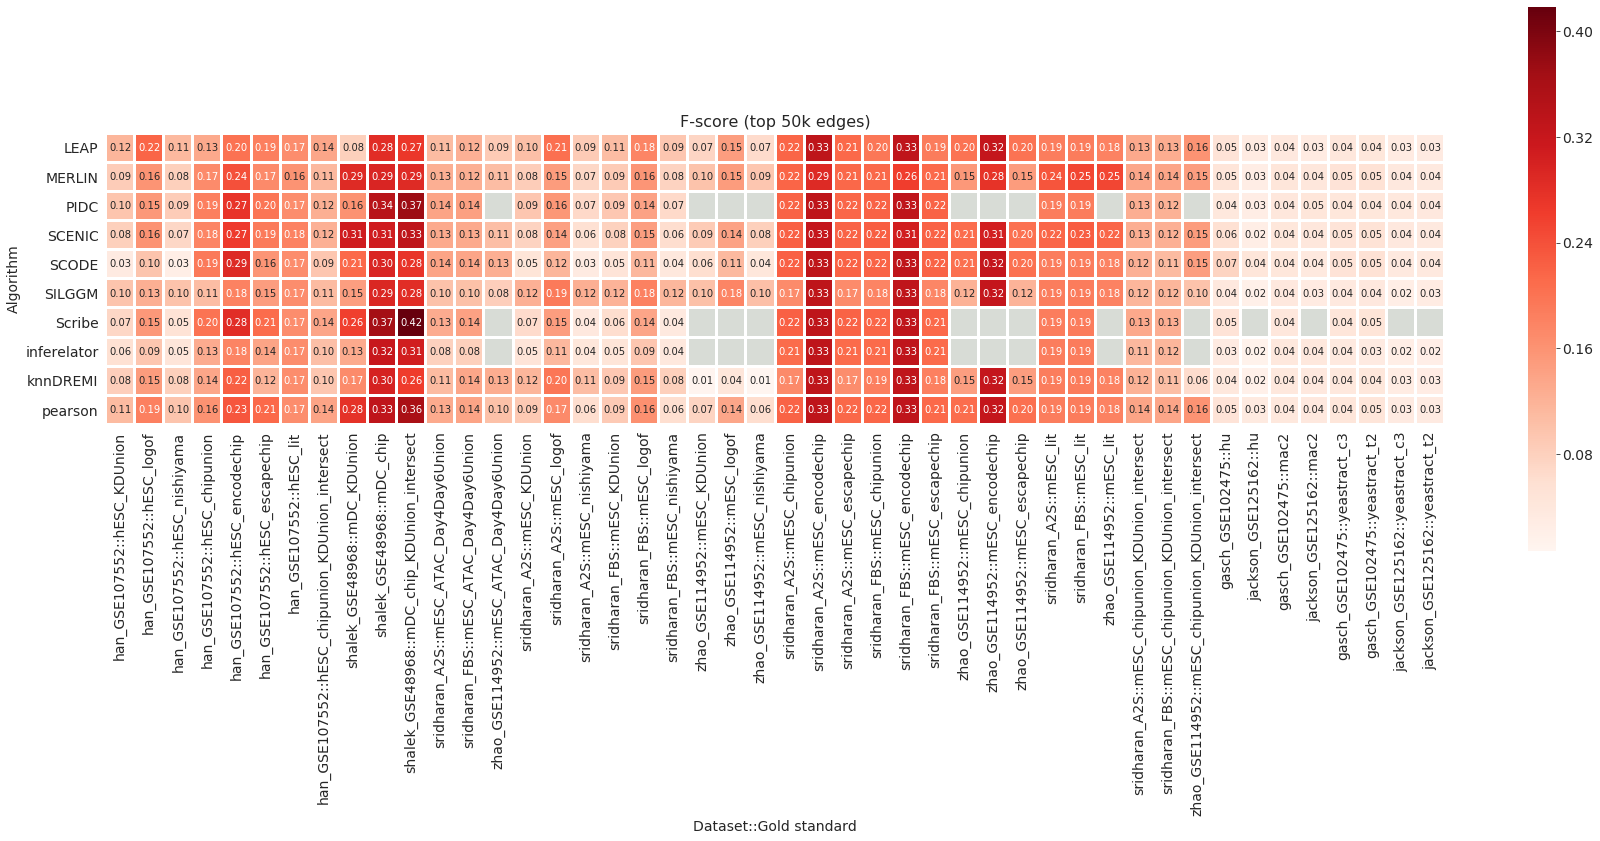

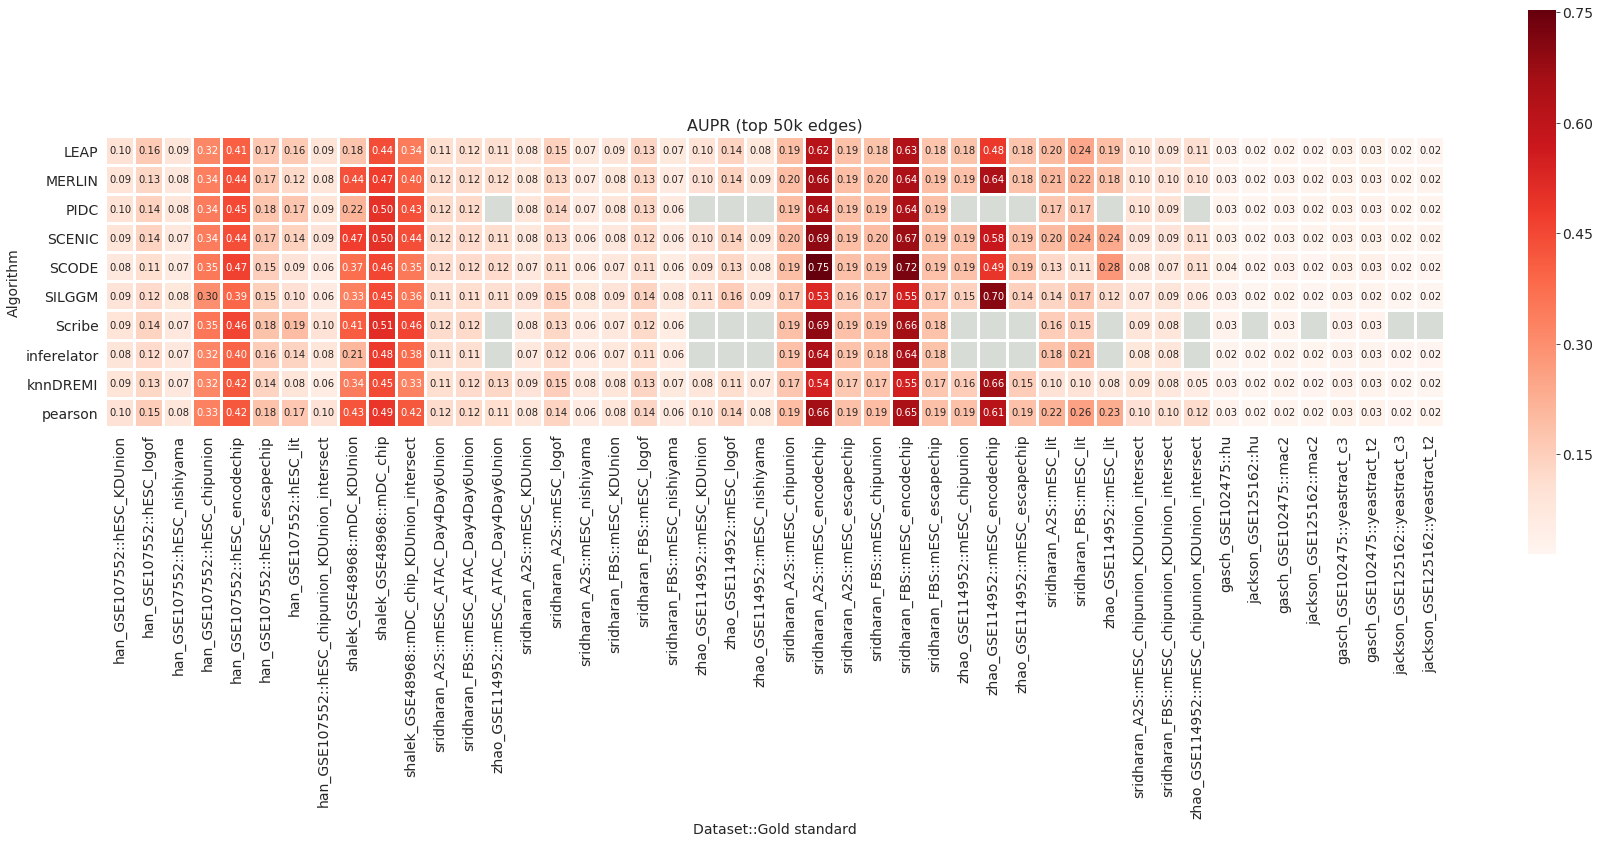

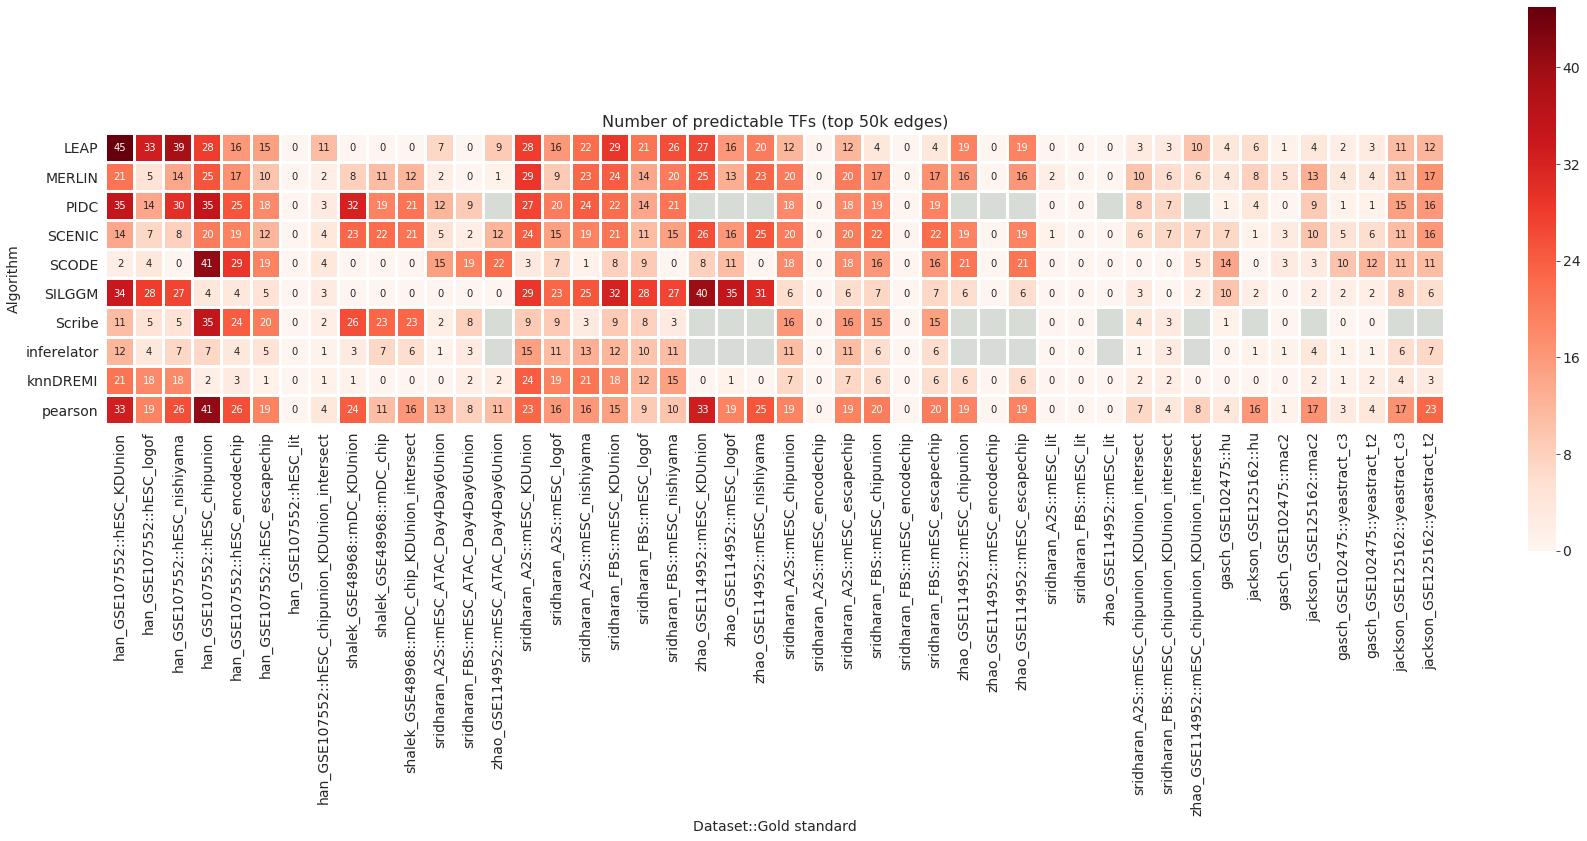

In [207]:
figpath = os.path.join(OUTDIR, '20191217.fscore.normalized_50000.heatmap.png')
make_heatmap('fscore', 50000, 'F-score', figpath=figpath)

figpath = os.path.join(OUTDIR, '20191217.aupr.normalized_50000.heatmap.png')
make_heatmap('AUPR', 50000, 'AUPR', figpath=figpath)

figpath = os.path.join(OUTDIR, '20191217.predTFs.normalized_50000.heatmap.png')
make_heatmap('n_TFs', 50000, 'Number of predictable TFs', figpath=figpath)

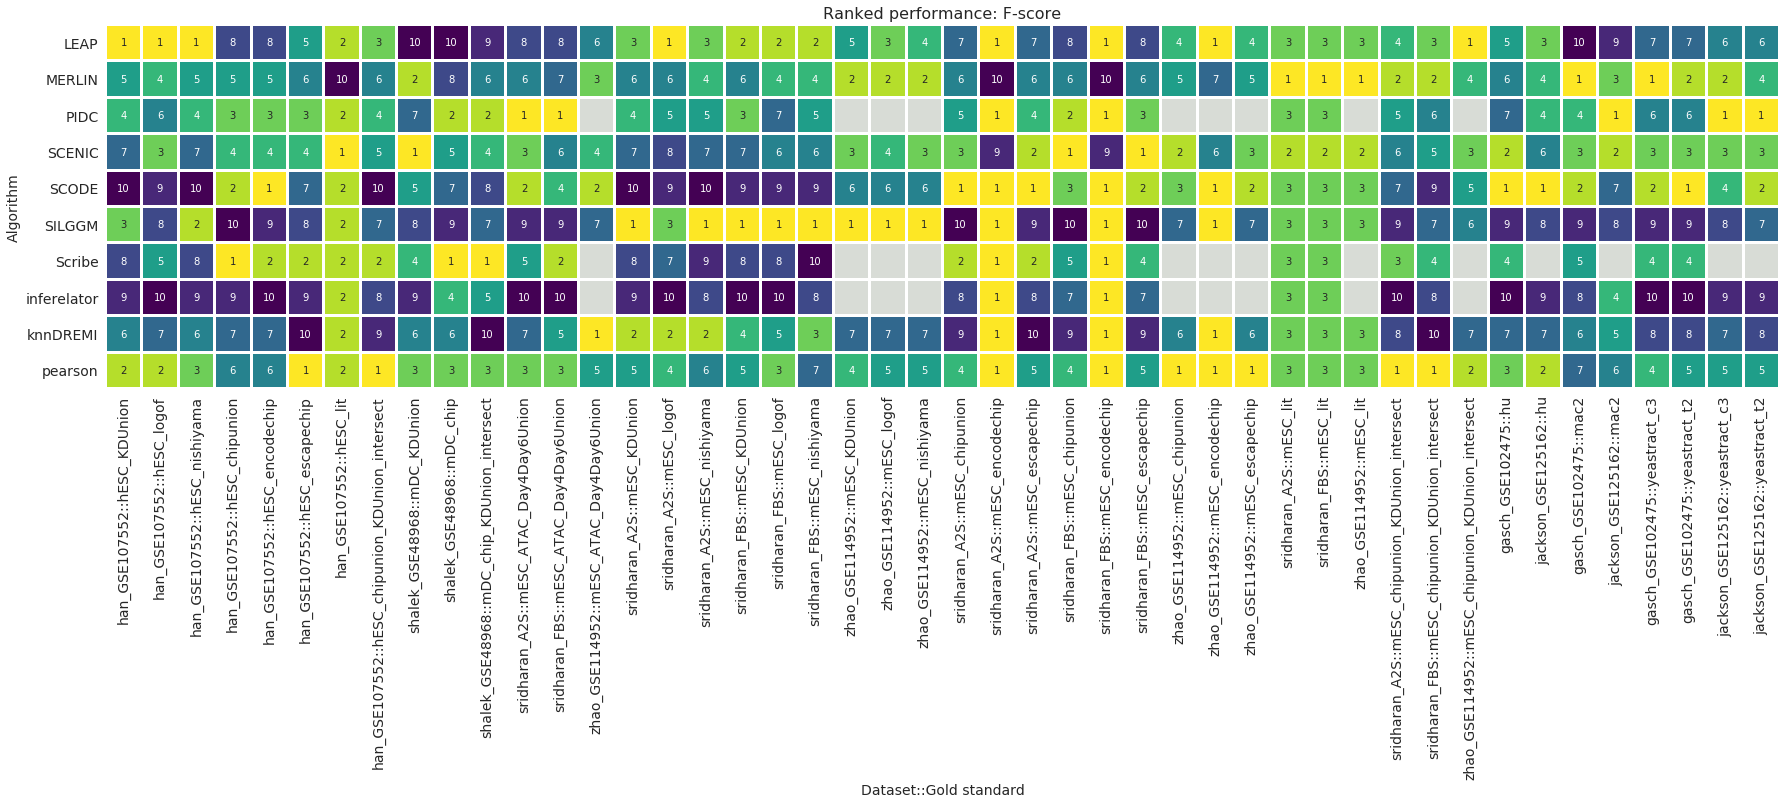

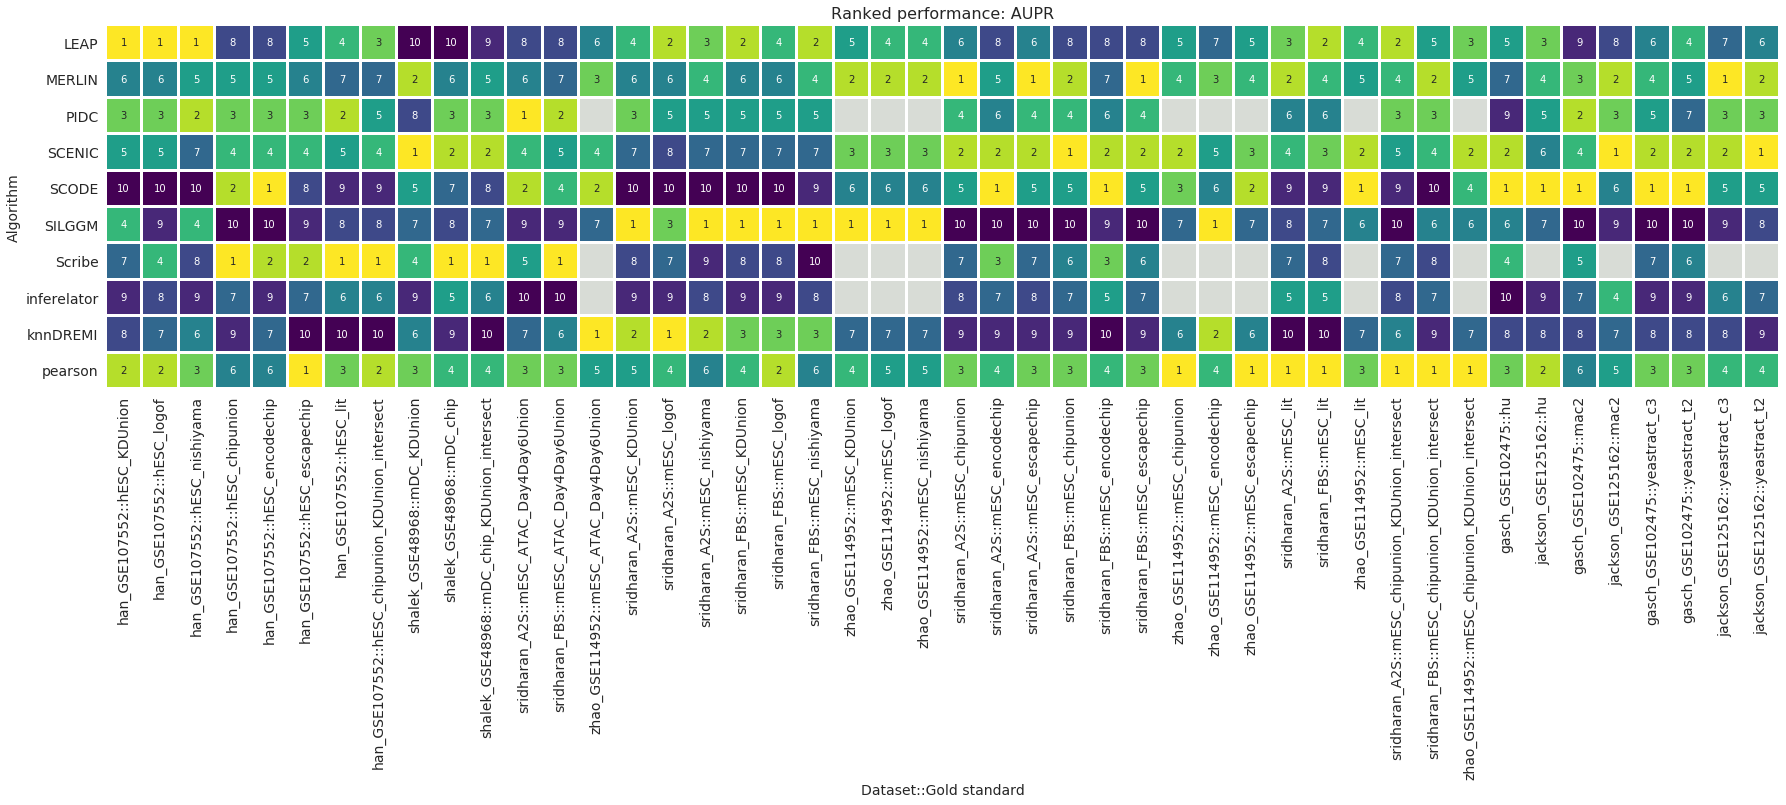

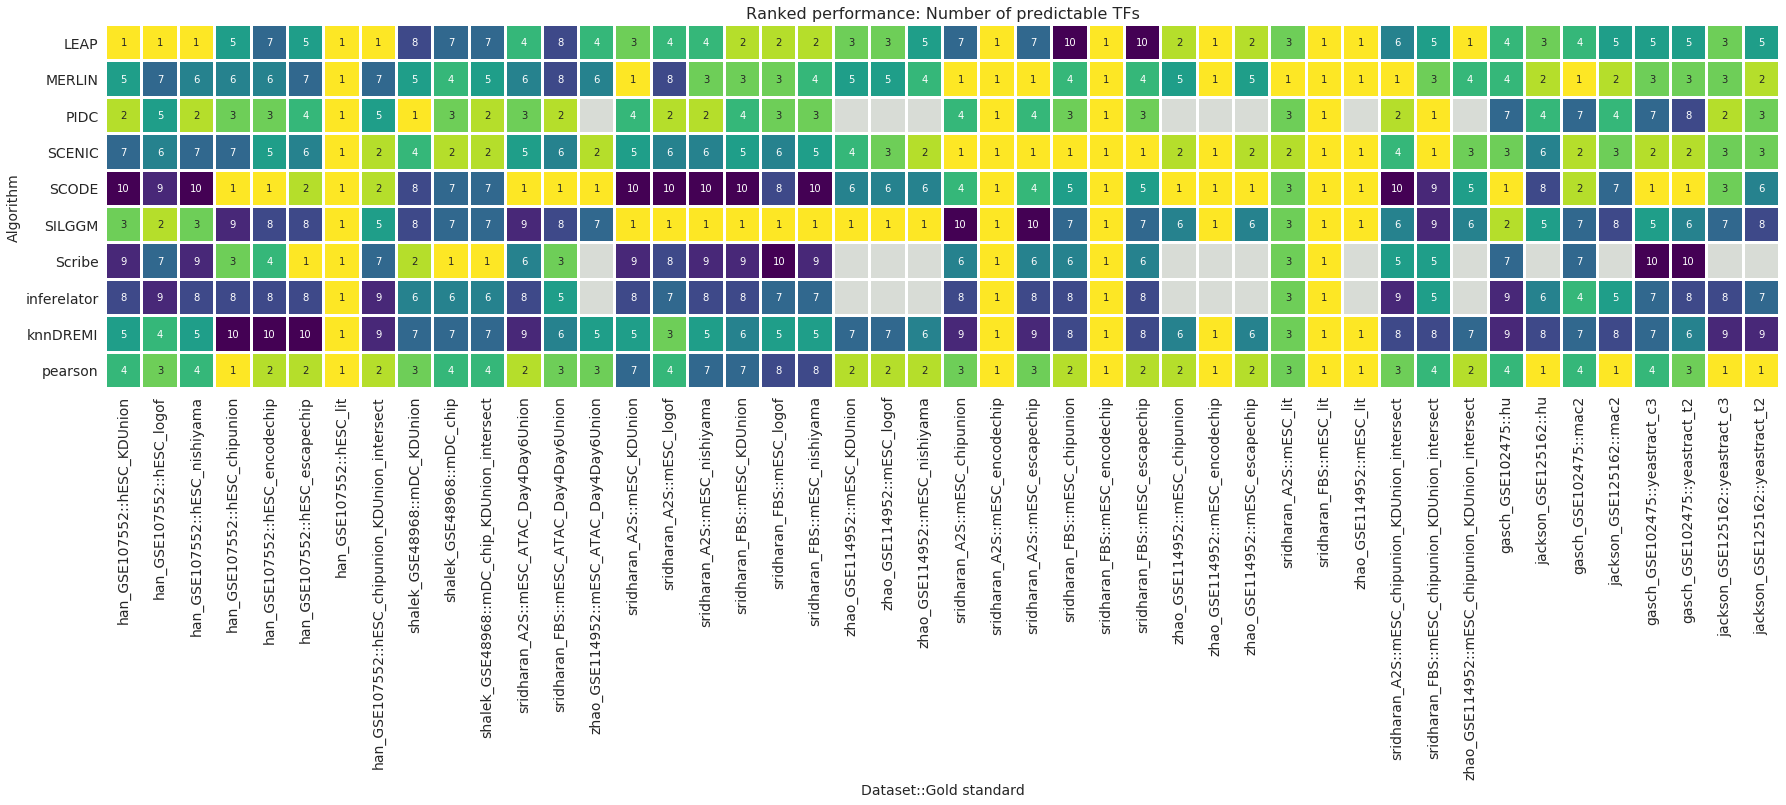

In [198]:
figpath = os.path.join(OUTDIR, '20191217.fscore.normalized_50000.heatmap_ranked.png')
make_heatmap('fscore', 50000, 'F-score', rank=True, figpath=figpath)

figpath = os.path.join(OUTDIR, '20191217.aupr.normalized_50000.heatmap_ranked.png')
make_heatmap('AUPR', 50000, 'AUPR', rank=True, figpath=figpath)

figpath = os.path.join(OUTDIR, '20191217.predTFs.normalized_50000.heatmap_ranked.png')
make_heatmap('n_TFs', 50000, 'Number of predictable TFs', rank=True, figpath=figpath)

0.01 0.16391304347826088
0.1839130434782609 0.7508695652173913
0.7708695652173914 0.8160869565217391
0.8360869565217391 0.99


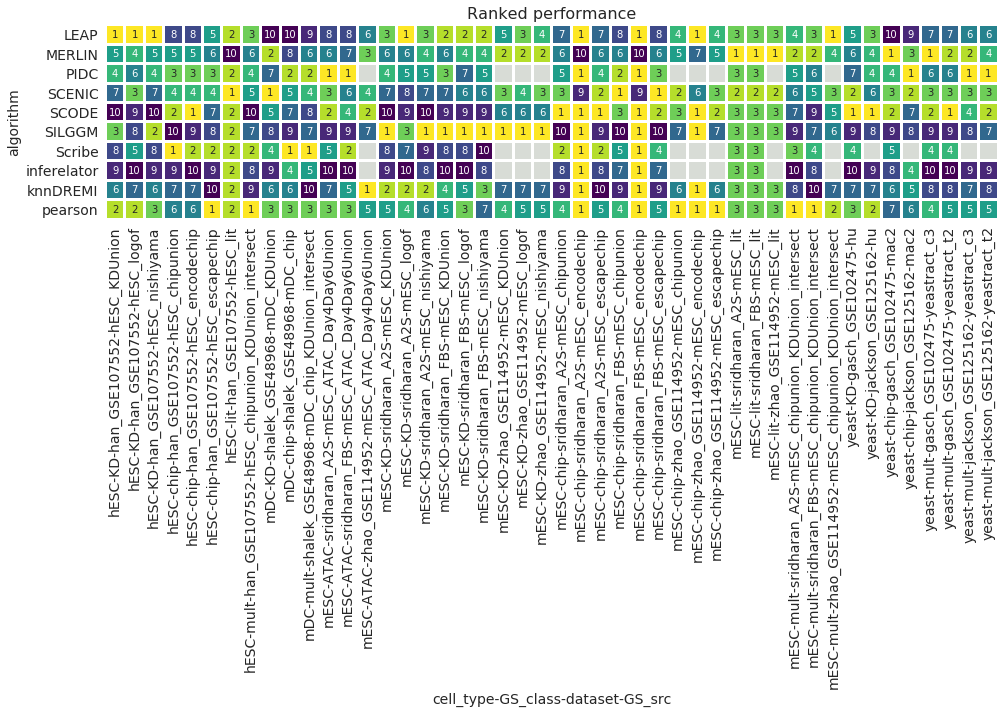

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax = sns.heatmap(hmap.rank(axis=1, ascending=False, method='min').T, ax=ax,
                 annot=True, fmt='.0f', 
                 cbar=False, mask=hmap.T.isnull(),
                 cmap='viridis_r', square=True,
                 linewidths=2)
ax.set_title('Ranked performance')
ax.set_facecolor(sns.xkcd_rgb['light grey'])
# ax.set_xticklabels([])

line_widths = hmap.reset_index().cell_type.value_counts() / hmap.shape[0]
space = 0.01

pos = 0
for cell_type in cell_type_order:
    pos += space
    xmin = pos
    xmax = pos + line_widths.loc[cell_type] - 2*space
    pos = xmax + space
    
    print(xmin, xmax)
#     ax.axhline(11, xmin, xmax, linewidth=7, color='k')
#     line = plt.Line2D([xmin, xmax], [1, 0], color='k', linewidth=7, clip_on=False)
    line = plt.Line2D([0, 1], [1, 0], color='k', linewidth=2, clip_on=False)
    
#     line.set_clip_on(False)

In [7]:
def plot_fscore_heatmaps(fscores):
    hmap = fscores.pivot_table(index='dataset', columns='algorithm', values='fscore')
    hmap = hmap.loc[DATASETS, ALGORITHMS]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

    ax = axes[0]
    ax = sns.heatmap(hmap, ax=ax,
                     annot=True, fmt='.03f',
                     cbar=False, mask=hmap.isnull(),
                     cmap='viridis', square=True,
                     linewidths=2)
    ax.set_title('F-scores (top 50k edges)')
    ax.set_facecolor(sns.xkcd_rgb['light grey'])

    ax = axes[1]
    ax = sns.heatmap(hmap.rank(axis=1, ascending=False), ax=ax,
                     annot=True, fmt='.0f', 
                     cbar=False, mask=hmap.isnull(),
                     cmap='viridis_r', square=True,
                     linewidths=2)
    ax.set_title('Ranked performance')
    ax.set_facecolor(sns.xkcd_rgb['light grey'])
    ax.set_yticklabels([])
    
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.tight_layout()
    

    
    return fig, axes

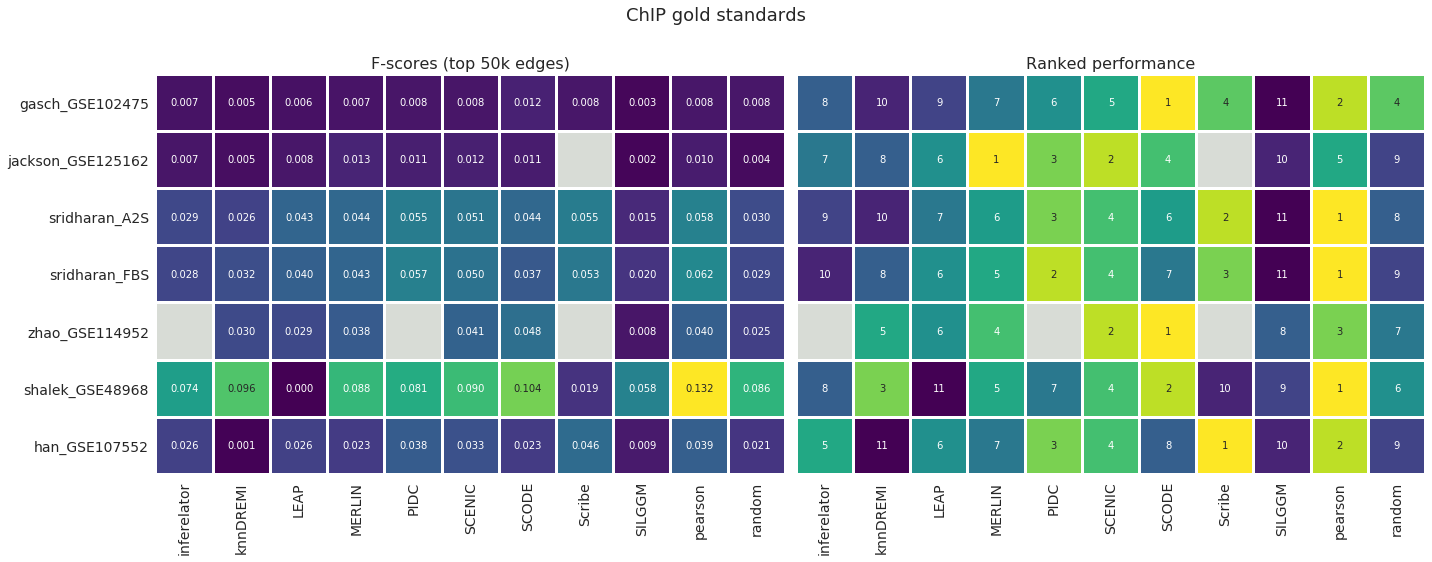

In [8]:
fig, axes = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'ChIP') &
                                            (fscores.n_edges == 50000)])

plt.subplots_adjust(top=0.97)
fig.suptitle('ChIP gold standards')
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.chip_50k.pdf'), bbox_inches='tight')

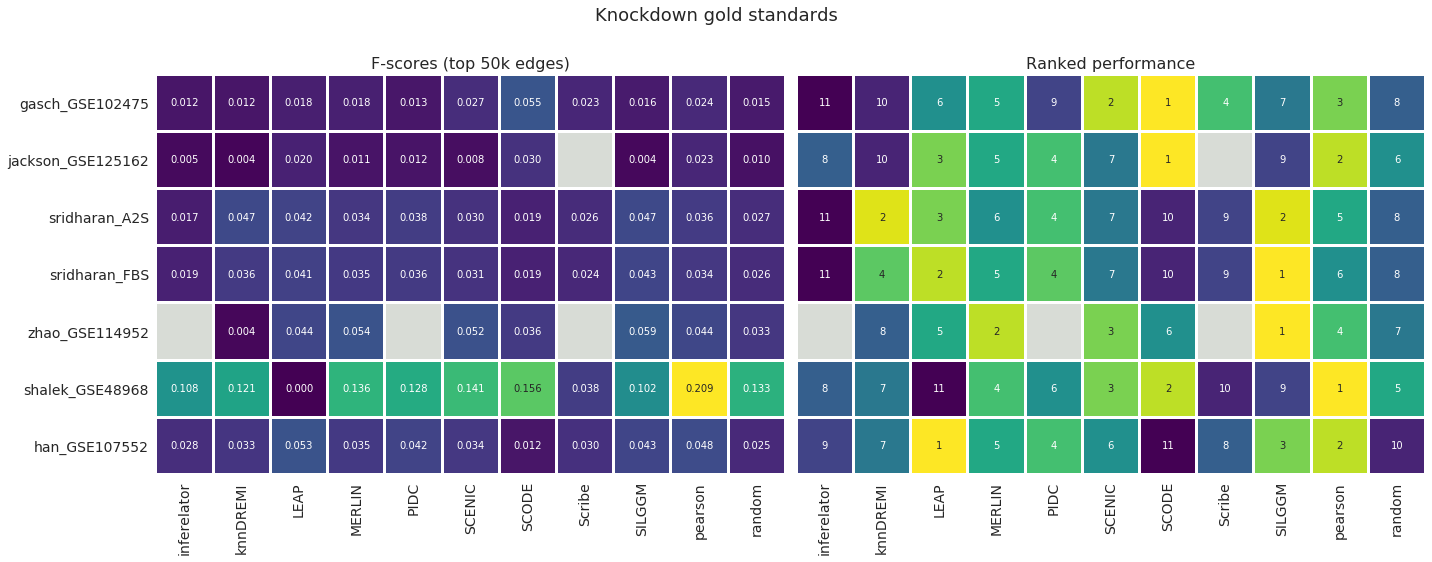

In [9]:
fig, axes = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'Knockdown') &
                                 (fscores.n_edges == 50000)])

plt.subplots_adjust(top=0.97)
fig.suptitle('Knockdown gold standards')
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.knockdown_50k.pdf'), bbox_inches='tight')

## normalized per row

In [10]:
from matplotlib import gridspec

In [11]:
def plot_fscore_heatmaps(fscores):
    hmap = fscores.pivot_table(index='dataset', columns='algorithm', values='fscore')
    hmap = hmap.loc[DATASETS, ALGORITHMS]
    
#     fig, axes = plt.subplots(7, 2, figsize=(20, 8), sharey=False)
    fig = plt.figure(figsize=(20, 8))
    gs = gridspec.GridSpec(7, 2)

#     gs.update(hspace=-0.2)

    for i, dataset in enumerate(DATASETS):
        ax = fig.add_subplot(gs[i, 0])
        dat = hmap.loc[dataset].to_frame().transpose()
        ax = sns.heatmap(dat, ax=ax,
                         annot=True, fmt='.03f',
                         cbar=False, #mask=hmap.isnull(),
                         cmap="RdBu_r", square=True,
                         center=hmap.loc[dataset, 'random'],
                         linewidths=2)
        if i == 0:
            ax.set_title('F-scores (top 50k edges)')
        ax.set_facecolor(sns.xkcd_rgb['light grey'])
        ax.set_xticklabels([])
        ax.set_yticklabels([dataset], rotation=0, ha='right')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        
        if dataset.startswith('han'):
            ax.set_xticklabels(ALGORITHMS)
            
    for i, dataset in enumerate(DATASETS):
        ax = fig.add_subplot(gs[i, 1])
        dat = hmap.loc[dataset].to_frame().transpose()
        ax = sns.heatmap(dat.rank(axis=1, ascending=False, method='min'), ax=ax,
                         annot=True, fmt='.0f',
                         cbar=False, #mask=hmap.isnull(),
                         cmap="viridis_r", square=True,
                         linewidths=2)
        if i == 0:
            ax.set_title('Ranked performance')
        ax.set_facecolor(sns.xkcd_rgb['light grey'])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        
        if dataset.startswith('han'):
            ax.set_xticklabels(ALGORITHMS)
            
    gs.update(wspace=0.05, hspace=-0.8)
    
    return fig

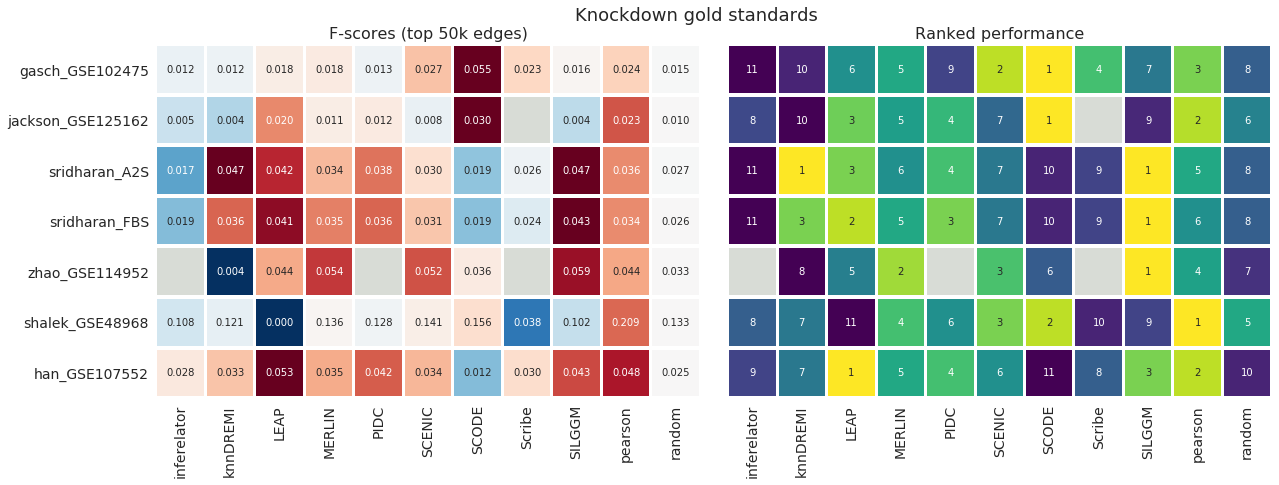

In [12]:
fig = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'Knockdown') &
                                 (fscores.n_edges == 50000)])

plt.subplots_adjust(top=1.09)
fig.suptitle('Knockdown gold standards')
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.knockdown_50k.v2.pdf'), bbox_inches='tight')

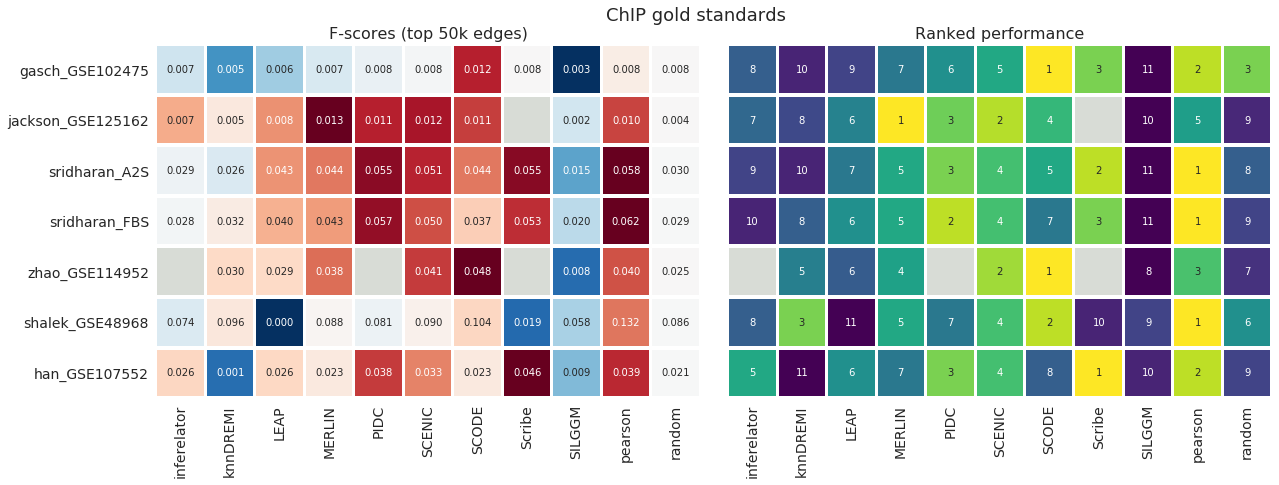

In [13]:
fig = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'ChIP') &
                                 (fscores.n_edges == 50000)])

plt.subplots_adjust(top=1.09)
fig.suptitle('ChIP gold standards')
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.chip_50k.v2.pdf'), bbox_inches='tight')

## Log2 change per row

In [14]:
def plot_fscore_heatmaps(fscores):
    hmap = fscores.pivot_table(index='dataset', columns='algorithm', values='fscore')
    hmap = hmap.loc[DATASETS, ALGORITHMS]
    
#     fig, axes = plt.subplots(7, 2, figsize=(20, 8), sharey=False)
    fig = plt.figure(figsize=(20, 8))
    gs = gridspec.GridSpec(7, 2)

#     gs.update(hspace=-0.2)

    for i, dataset in enumerate(DATASETS):
        ax = fig.add_subplot(gs[i, 0])
        dat = hmap.loc[dataset].to_frame().transpose()
        fold_change = np.log2(dat.div(dat.random, axis='index'))
        ax = sns.heatmap(fold_change, ax=ax,
                         annot=dat.values, fmt='.03f',
                         cbar=False, #mask=hmap.isnull(),
                         cmap="RdBu_r", square=True,
                         center=hmap.loc[dataset, 'random'],
                         linewidths=2)
        if i == 0:
            ax.set_title('F-scores (top 50k edges)')
        ax.set_facecolor(sns.xkcd_rgb['light grey'])
        ax.set_xticklabels([])
        ax.set_yticklabels([dataset], rotation=0, ha='right')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        
        if dataset.startswith('han'):
            ax.set_xticklabels(ALGORITHMS)
            
    for i, dataset in enumerate(DATASETS):
        ax = fig.add_subplot(gs[i, 1])
        dat = hmap.loc[dataset].to_frame().transpose()
        ax = sns.heatmap(dat.rank(axis=1, ascending=False, method='min'), ax=ax,
                         annot=True, fmt='.0f',
                         cbar=False, #mask=hmap.isnull(),
                         cmap="viridis_r", square=True,
                         linewidths=2)
        if i == 0:
            ax.set_title('Ranked performance')
        ax.set_facecolor(sns.xkcd_rgb['light grey'])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        
        if dataset.startswith('han'):
            ax.set_xticklabels(ALGORITHMS)
            
    gs.update(wspace=0.05, hspace=-0.8)
    
    return fig

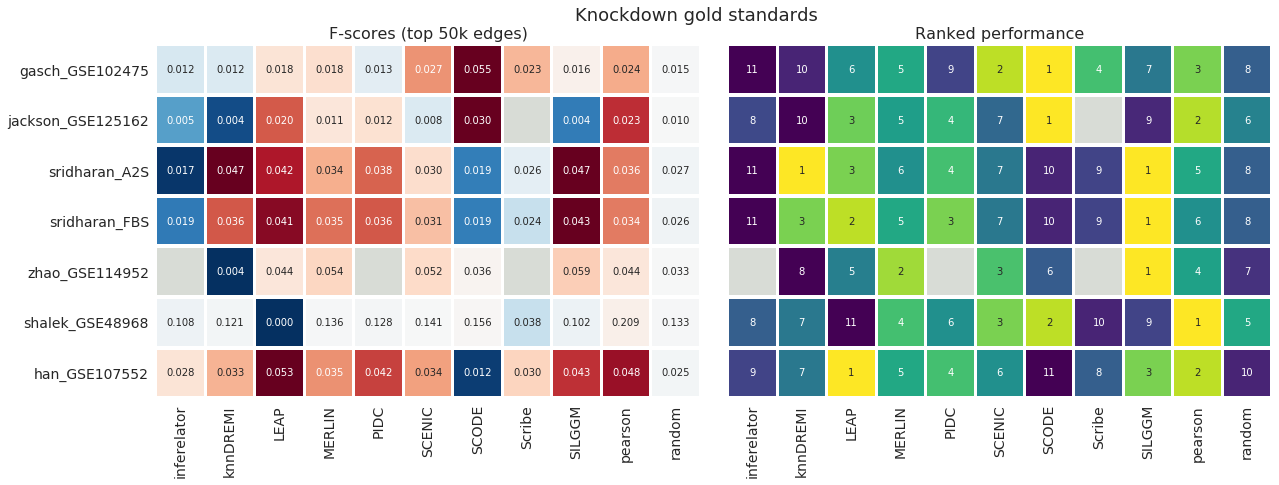

In [15]:
fig = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'Knockdown') &
                                 (fscores.n_edges == 50000)])

plt.subplots_adjust(top=1.09)
fig.suptitle('Knockdown gold standards')
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.knockdown_50k.v3.pdf'), bbox_inches='tight')

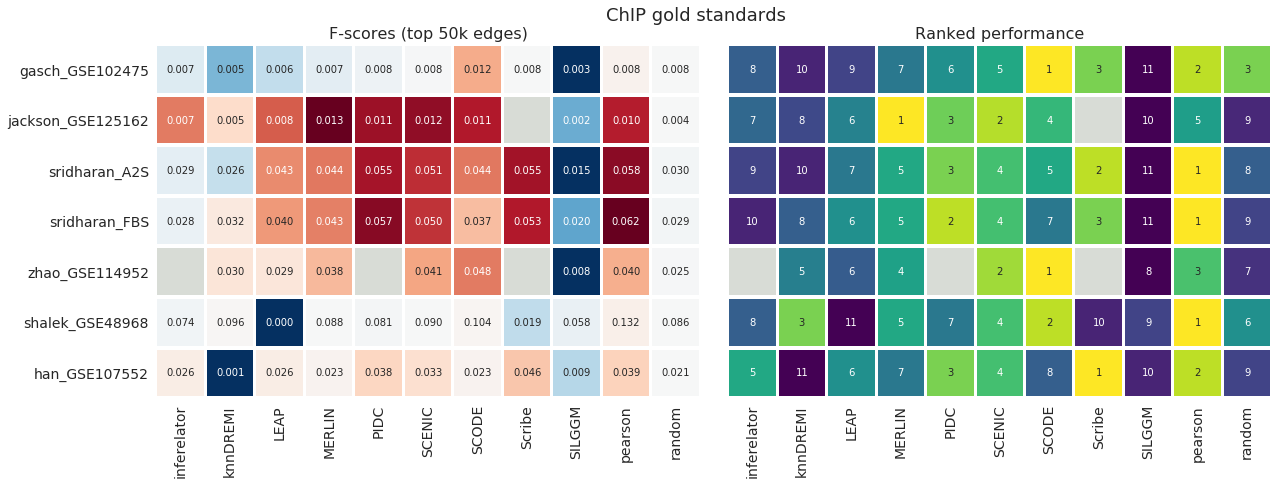

In [16]:
fig = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'ChIP') &
                                 (fscores.n_edges == 50000)])

plt.subplots_adjust(top=1.09)
fig.suptitle('ChIP gold standards')
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.chip_50k.v3.pdf'), bbox_inches='tight')

In [54]:
test = fscores.loc[(fscores.simple_GS == 'Knockdown') &
                   (fscores.n_edges == 50000)]
hmap = test.pivot_table(index='dataset', columns='algorithm', values='fscore')
hmap = hmap.loc[DATASETS, ALGORITHMS]

In [58]:
alg_titles = [x for x in ALGORITHMS]
alg_titles[0] = 'Inferelator'
alg_titles[1] = 'kNN-DREMI'
alg_titles[-2] = 'Pearson'
alg_titles[-1] = 'Random'

In [73]:
def plot_fscore_heatmaps(fscores):
    hmap = fscores.pivot_table(index='dataset', columns='algorithm', values='fscore')
    hmap = hmap.loc[DATASETS, ALGORITHMS]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

    ax = axes[0]
    ax = sns.heatmap(np.log2(hmap.div(hmap.random, axis='index')), ax=ax,
                     annot=hmap, fmt='.03f', annot_kws={'fontsize': 15},
                     cbar=False, mask=hmap.isnull(),
                     center=0,
                     robust=True,
                     cmap='RdBu_r', square=True,
                     linewidths=2)
    ax.set_title('F-score (top 50k edges)')
    ax.set_facecolor(sns.xkcd_rgb['light grey'])

    ax = axes[1]
    ranks = hmap.copy()
    ranks['random'] = -1
    ranks = ranks.rank(axis=1, ascending=False)
    ax = sns.heatmap(ranks, ax=ax,
                     annot=True, fmt='.0f', annot_kws={'fontsize': 16},
                     cbar=False, mask=ranks.isnull(),
                     cmap='viridis_r', square=True,
                     linewidths=2)
    ax.set_title('Ranked performance')
    ax.set_facecolor(sns.xkcd_rgb['light grey'])
    ax.set_yticklabels([])
    
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.tight_layout()
    

    
    return fig, axes

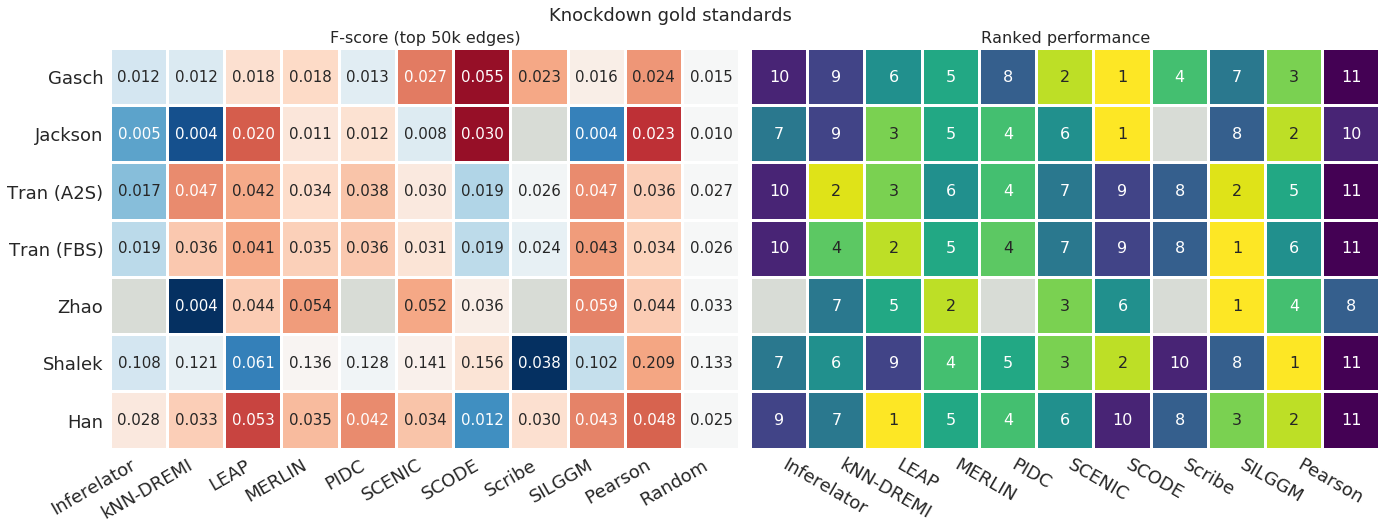

In [96]:
fig, axes = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'Knockdown') &
                                 (fscores.n_edges == 50000)])

plt.subplots_adjust(top=1.06)
fig.suptitle('Knockdown gold standards')

axes[0].set_yticklabels(['Gasch', 'Jackson', 'Tran (A2S)', 'Tran (FBS)', 'Zhao', 'Shalek', 'Han'], fontsize=18)

for ax in axes:
    ax.set_xticklabels(alg_titles, rotation=30, ha='right', fontsize=18)
axes[1].set_xticklabels(alg_titles[:-1], rotation=330, ha='left', fontsize=18)
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.knockdown_50k.poster.pdf'), bbox_inches='tight')

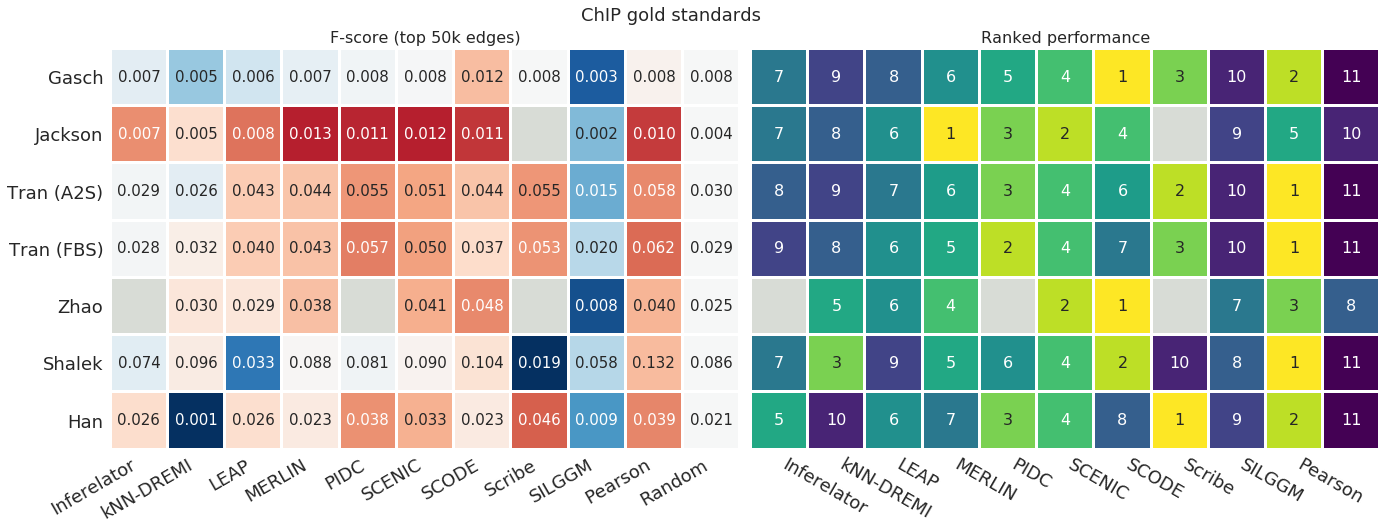

In [97]:
fig, axes = plot_fscore_heatmaps(fscores.loc[(fscores.simple_GS == 'ChIP') &
                                 (fscores.n_edges == 50000)])

plt.subplots_adjust(top=1.06)
fig.suptitle('ChIP gold standards')

axes[0].set_yticklabels(['Gasch', 'Jackson', 'Tran (A2S)', 'Tran (FBS)', 'Zhao', 'Shalek', 'Han'], fontsize=18)

for ax in axes:
    ax.set_xticklabels(alg_titles, rotation=30, ha='right', fontsize=18)
axes[1].set_xticklabels(alg_titles[:-1], rotation=330, ha='left', fontsize=18)
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap.chip_50k.poster.pdf'), bbox_inches='tight')

## With predictable TFs

In [116]:
kd_pTF = pd.read_table('results/predictable_TFs/ko.50000.txt', index_col=0)
chip_pTF = pd.read_table('results/predictable_TFs/chip.50000.txt', index_col=0)

In [101]:
kd_pTF.head()

Inferelator  kNN-DREMI  LEAP  MERLIN  PIDC  SCENIC  SCODE  Scribe  \
Name                                                                           
Gasch              0.0          0     1       2   1.0       6      5     0.0   
Jackson            1.0          0     5       4   4.0       2     11     NaN   
Tran(A2S)         14.0         20    21      25  27.0      24      3     9.0   
Tran(FBS)         12.0          8    19      23  23.0      21     10     9.0   
Zhao               NaN          1    15      25   NaN      25     11     NaN   

           SILGGM  Pearson  Random  
Name                                
Gasch           8        4       7  
Jackson         1        5      12  
Tran(A2S)      27       15       5  
Tran(FBS)      24       11       5  
Zhao           21       21       6

In [112]:
def plot_fscore_heatmaps_with_predTFs(fscores, pred_TFs):
    hmap = fscores.pivot_table(index='dataset', columns='algorithm', values='fscore')
    hmap = hmap.loc[DATASETS, ALGORITHMS]
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=False)

    ax = axes[0]
    ax = sns.heatmap(np.log2(hmap.div(hmap.random, axis='index')), ax=ax,
                     annot=hmap, fmt='.03f', annot_kws={'fontsize': 15},
                     cbar=False, mask=hmap.isnull(),
                     center=0,
                     robust=True,
                     cmap='RdBu_r', square=True,
                     linewidths=2)
    ax.set_title('F-score (top 50k edges)')
    ax.set_facecolor(sns.xkcd_rgb['light grey'])

    ax = axes[1]
    ranks = hmap.copy()
    ranks['random'] = -1
    ranks = ranks.rank(axis=1, ascending=False)
    ax = sns.heatmap(ranks, ax=ax,
                     annot=True, fmt='.0f', annot_kws={'fontsize': 16},
                     cbar=False, mask=ranks.isnull(),
                     cmap='viridis_r', square=True,
                     linewidths=2)
    ax.set_title('Ranked performance')
    ax.set_facecolor(sns.xkcd_rgb['light grey'])
    ax.set_yticklabels([])
    
    ax = axes[2]
    ax = sns.heatmap(pred_TFs, ax=ax,
                     annot=True, fmt='.0f', annot_kws={'fontsize': 16},
                     cbar=False, mask=pred_TFs.isnull(),
                     cmap='Reds', square=True,
                     linewidths=2)
    ax.set_yticklabels([])
    ax.set_title('Predictable TFs')
    
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_facecolor(sns.xkcd_rgb['light grey'])
    plt.tight_layout()
    

    
    return fig, axes

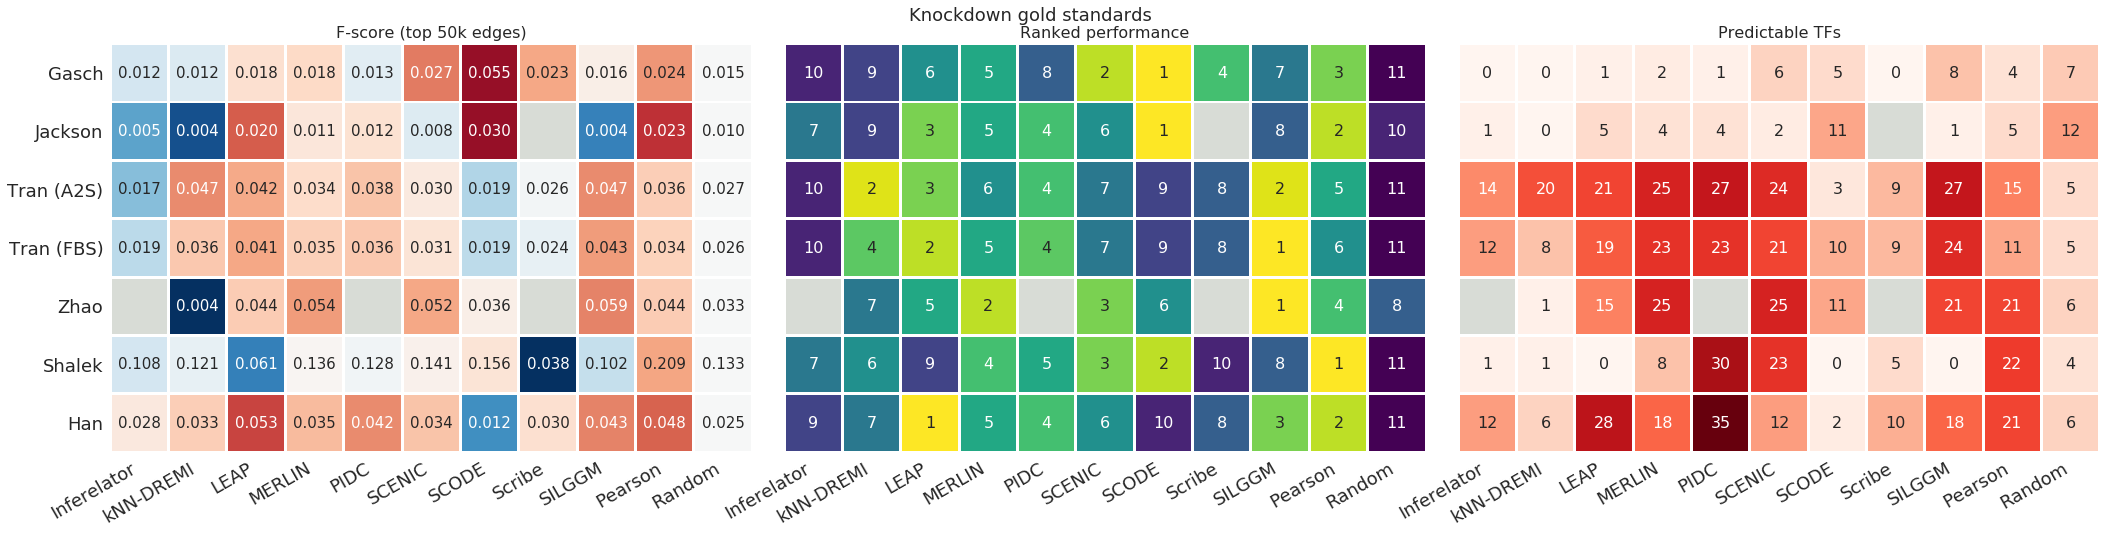

In [114]:
fig, axes = plot_fscore_heatmaps_with_predTFs(fscores.loc[(fscores.simple_GS == 'Knockdown') &
                                 (fscores.n_edges == 50000)],
                                 kd_pTF)

plt.subplots_adjust(top=1.06)
plt.subplots_adjust(wspace=0.05)
fig.suptitle('Knockdown gold standards')

axes[0].set_yticklabels(['Gasch', 'Jackson', 'Tran (A2S)', 'Tran (FBS)', 'Zhao', 'Shalek', 'Han'], fontsize=18)

for ax in axes:
    ax.set_xticklabels(alg_titles, rotation=30, ha='right', fontsize=18)
# axes[1].set_xticklabels(alg_titles[:-1], rotation=330, ha='left', fontsize=18)
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap_with_predTFs.knockdown_50k.poster.pdf'), bbox_inches='tight')

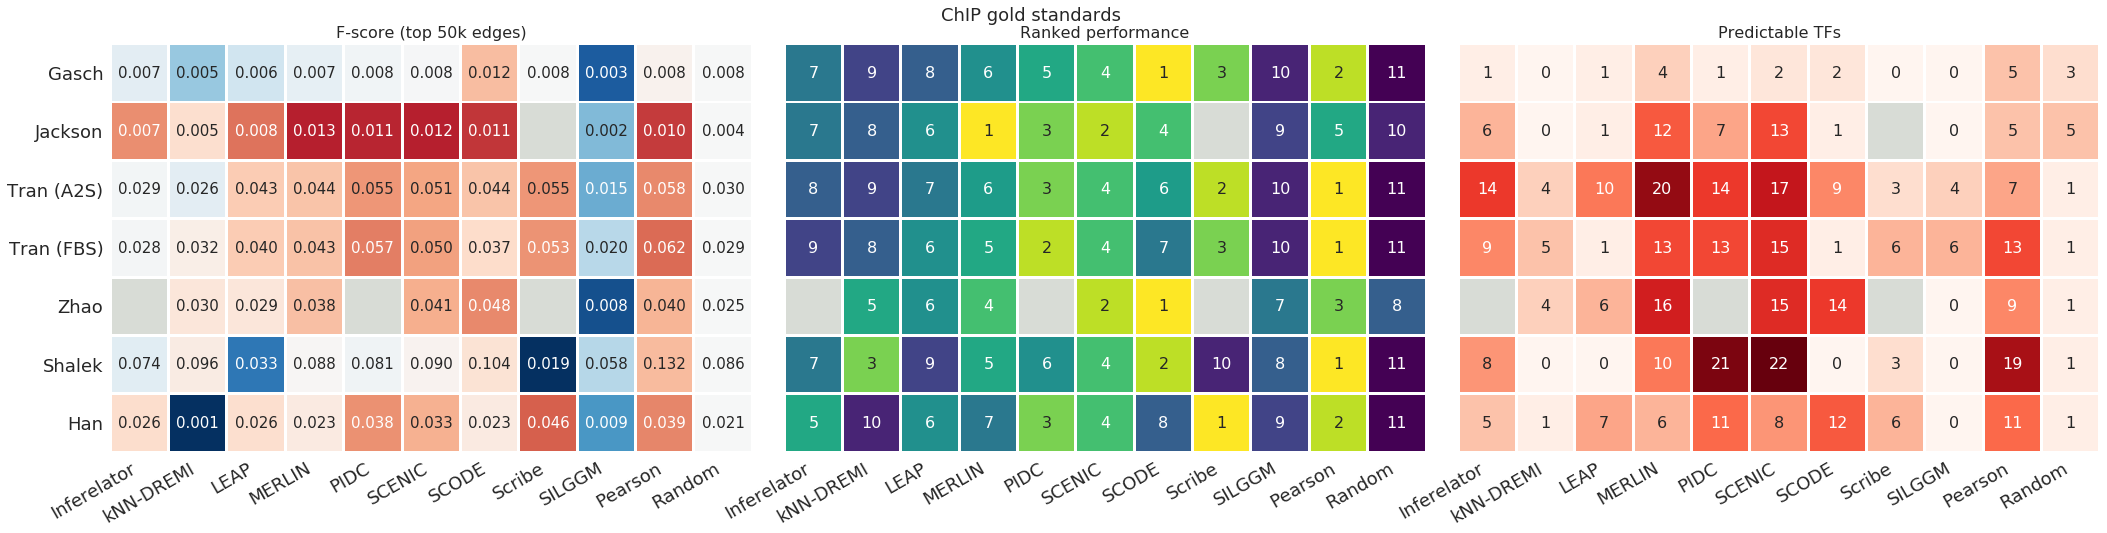

In [118]:
fig, axes = plot_fscore_heatmaps_with_predTFs(fscores.loc[(fscores.simple_GS == 'ChIP') &
                                 (fscores.n_edges == 50000)],
                                 chip_pTF)

plt.subplots_adjust(top=1.06)
plt.subplots_adjust(wspace=0.05)
fig.suptitle('ChIP gold standards')

axes[0].set_yticklabels(['Gasch', 'Jackson', 'Tran (A2S)', 'Tran (FBS)', 'Zhao', 'Shalek', 'Han'], fontsize=18)

for ax in axes:
    ax.set_xticklabels(alg_titles, rotation=30, ha='right', fontsize=18)
# axes[1].set_xticklabels(alg_titles[:-1], rotation=330, ha='left', fontsize=18)
plt.savefig(os.path.join(OUTDIR, 'fscore_heatmap_with_predTFs.chip_50k.poster.pdf'), bbox_inches='tight')

In [120]:
hmaps = []
for GS in ['Knockdown', 'ChIP']:
    dat = fscores.loc[(fscores.n_edges == 50000) &
                      (fscores.simple_GS == GS)]
    
    hmap = dat.pivot_table(index='dataset', columns='algorithm', values='fscore')
    hmap = hmap.loc[DATASETS, ALGORITHMS]
    
    hmaps.append(hmap)

In [139]:
def reformat_pTF(pTF):
    pTF.index = DATASETS

    pTF = pTF.rename(columns={'Inferelator': 'inferelator',
                              'Pearson': "pearson",
                              'Random': 'random',
                              'kNN-DREMI': 'knnDREMI'})
    
    pTF = pTF.loc[DATASETS, ALGORITHMS]
    return pTF

In [140]:
kd_pTF = reformat_pTF(kd_pTF)
chip_pTF = reformat_pTF(chip_pTF)

In [143]:
scores = pd.concat(hmaps + [kd_pTF, chip_pTF])

In [181]:
avg = scores[ALGORITHMS[:-1]].rank(axis=1, ascending=False).median(axis=0)

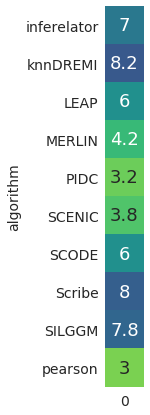

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(2, 7))

sns.heatmap(avg.to_frame(), annot=True,
            annot_kws={'fontsize': 18},
            square=True,
            cmap='viridis_r', cbar=False,
            vmin=1, vmax=11)

In [ ]:
hmaps = []
for GS in ['Knockdown', 'ChIP']:
    dat = fscores.loc[(fscores.n_edges == 50000) &
                      (fscores.simple_GS == GS)]
    
    hmap = dat.pivot_table(index='dataset', columns='algorithm', values='fscore')
    hmap = hmap.loc[DATASETS, ALGORITHMS]
    
    hmaps.append(hmap)

In [183]:
kd_scores = pd.concat([hmaps[0], kd_pTF])
kd_avg = kd_scores.drop('random', axis=1).rank(axis=1, ascending=False, method='min').mean(axis=0)

chip_scores = pd.concat([hmaps[1], chip_pTF])
chip_avg = chip_scores.drop('random', axis=1).rank(axis=1, ascending=False, method='min').mean(axis=0)

Text(0.5, 1, 'ChIP')

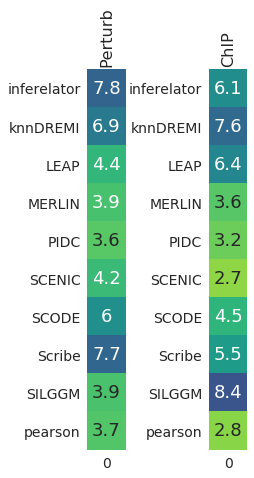

In [184]:
fig, axes = plt.subplots(1, 2, figsize=(4, 7))

ax = axes[0]
sns.heatmap(kd_avg.to_frame(), annot=True,
            annot_kws={'fontsize': 18},
            square=True,
            cmap='viridis_r', cbar=False,
            vmin=1, vmax=11,
            ax=ax)
ax.set_ylabel('')
ax.set_title('Perturb', rotation=90)

ax = axes[1]
sns.heatmap(chip_avg.to_frame(), annot=True,
            annot_kws={'fontsize': 18},
            square=True,
            cmap='viridis_r', cbar=False,
            vmin=1, vmax=11,
            ax=ax)
ax.set_ylabel('')
ax.set_title('ChIP', rotation=90)

In [185]:
kd_scores = pd.concat([hmaps[0], kd_pTF])
kd_avg = kd_scores.drop('random', axis=1).rank(axis=1, ascending=False, method='min').median(axis=0)

chip_scores = pd.concat([hmaps[1], chip_pTF])
chip_avg = chip_scores.drop('random', axis=1).rank(axis=1, ascending=False, method='min').median(axis=0)

In [226]:
rank_hmap = pd.concat([
    kd_avg.rename('Perturb').to_frame().transpose(),
    chip_avg.rename('ChIP').to_frame().transpose()
])

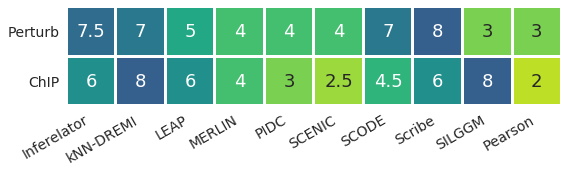

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.heatmap(rank_hmap, annot=True,
            annot_kws={'fontsize': 18},
            square=True,
            cmap='viridis_r', cbar=False,
            vmin=1, vmax=11,
            linewidths=2,
            ax=ax)
ax.set_ylabel('')
# ax.set_title('Perturb', rotation=90)
ax.set_xlabel('')

# ax.set_title('ChIP', rotation=90)

_ = ax.set_xticklabels(alg_titles[:-1], rotation=30, ha='right')
# plt.savefig(os.path.join(OUTDIR, ))

plt.tight_layout()

plt.savefig(os.path.join(OUTDIR, 'performance_ranks.pdf'), bbox_inches='tight')